In [ ]:
!pip install sastrawi pyldavis openai==0.28 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.0 MB/s eta 0:00:00


In [ ]:
# import library

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline as imb_Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import confusion_matrix, classification_report
from wordcloud import WordCloud
import warnings
import gensim.corpora as corpora
from gensim.models import TfidfModel, Phrases
import numpy as np
import openai
from tqdm import tqdm

warnings.filterwarnings('ignore')
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [ ]:
# membaca data
datas = pd.read_excel('/content/Dataset.xlsx')
datas = datas.dropna(subset='review').reset_index(drop=True)

# Annotation

In [ ]:
# Masukkan API Key OpenAI Anda di sini
openai.api_key = ""

def analyze_sentiment(text):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4o-mini",
            messages = [
                {"role": "system", "content": "Anda adalah alat analisis sentimen yang akan mengklasifikasikan teks menjadi positif atau negatif."},
                {"role": "user", "content": f"Analisislah sentimen dari teks berikut ini dan tentukan apakah bersifat positif atau negatif tanpa memberikan penjelasan apapun.\n\nTeks: {text}"}
                ],
            max_tokens=5
        )
        sentiment = response['choices'][0]['message']['content'].strip().lower()

        if sentiment not in ["positif", "negatif"]:
          return None

        return sentiment

    except openai.OpenAIError as e:
        return f"Error: {str(e)}"

def analyze_sentiments_from_excel(file_path):
    df = pd.read_excel(file_path)

    if 'review' not in df.columns:
        return "File excel tidak memiliki kolom 'text'."  # Perbaiki nama kolom sesuai

    # Menggunakan tqdm untuk menampilkan progress bar saat memproses data
    sentiments = []
    for text in tqdm(df['review'][:10], desc="Memproses sentimen"):  # Gunakan kolom 'text'
        sentiments.append(analyze_sentiment(text))

    # df['label'] = sentiments

    # output_file = "Labeled Dataset.xlsx"
    # df.to_excel(output_file, index=False)
    # print(f"Hasil analisis sentimen disimpan ke '{output_file}'")

    print("Hasil analisis sentimen:")
    for i in range(10):
      print(f"Text: {df['review'][i]}")
      print(f"Sentiment: {sentiments[i]}")
      print()

    # return df

dataset_file = "/content/Dataset.xlsx"  # Ganti dengan nama file excel Anda
analyzed_data = analyze_sentiments_from_excel(dataset_file)

Memproses sentimen: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

Hasil analisis sentimen:
Text: Pelayanannya mantap 👍Dokter, perawat & petugasnya sangat sangat ramah Rekomendasi banget untuk bumil yang mau lahiran di RSIA Annisa
Sentiment: positif

Text: Seharusnya pelayanan bisa lebih baik, hanya saja malam ini, hr senin Tgl 20.05.2024 bagian penimbangan bayi, cek bayi tidak memuaskan, mohon perhatian management Rsia agar antrian terorganisir dengan baik. Jangan sampai terulang kembali dokter keluar ingin pulang padahal pasien anak masih ada yang ngantri. Mohon maaf sebelumnya, inilah kesan saya hari ini..Seharusnya pelayanan bisa lebih baik, hanya saja malam ini, hr senin Tgl 20.05.2024 bagian penimbangan bayi, cek bayi tidak memuaskan, mohon perhatian management Rsia agar antrian terorganisir dengan baik. Jangan sampai terulang kembali …More
Sentiment: negatif

Text: Selalu puas sama pelayanan di annisa, dari kehamilan pertama dan kehamilan kedua , selalu kontrol diAnnisa jg , semua staf nya bidan nya , dokter nya pokoknya semua nya ramah ramah😍 

In [ ]:
df = pd.read_excel('/content/Labeled Dataset.xlsx')
df['label'].value_counts()

,count
label,
positif,3534
negatif,1456


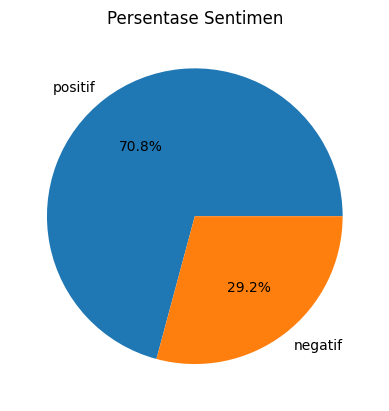

In [ ]:
plt.pie(df['label'].value_counts(), labels=df['label'].value_counts().index, autopct='%1.1f%%')
plt.title('Persentase Sentimen')
plt.show()

# Preprocessing


In [ ]:
def load(file): # Fungsi membaca kamus abbreviation (singkatan)
  f = open(file, "r")
  dic = {}
  for line in f:
    a,b = line.split(" = ")
    dic[a] = b[:-1]
  f.close()
  return dic

def change(text): # Fungsi merubah singkatan menjadi kata baku
  abb_dict = load(abb_dict_path)
  word = text.split()
  p = len(word)
  for i in range(p):
    if word[i] in abb_dict:
      word[i]=abb_dict[word[i]]
  return " ".join(word)

def remove_emoji(text): # Fungsi menghapus emoji
  emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # Emoji umum
                               u"\U0001F300-\U0001F5FF"  # Simbol & Pictographs
                               u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
                               u"\U0001F700-\U0001F77F"  # Alat & Kegiatan
                               u"\U0001F780-\U0001F7FF"  # Supplemental Symbols and Pictographs
                               u"\U0001F800-\U0001F8FF"  # Ideogram
                               u"\U0001F900-\U0001F9FF"  # Emoticons
                               u"\U0001FA00-\U0001FA6F"  # Supplemental Symbols and Pictographs
                               u"\U0001FA70-\U0001FAFF"  # Emoji Ekstensi
                               u"\U00002702-\U000027B0"  # Dingbat
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r' ', text)

  return text

def preprocessor(text):
  text = text.lower() # Case Folding
  text = remove_emoji(text) # Remove Emoji
  text = re.sub(r"[0-9]|[^\w\s]|_", " ", text) # Remove Number & Punct
  text = " ".join(text.split()) # Remove Whitespace
  text = re.sub("(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)", " ", text) # Remove Single Char
  text = change(text) # Text Normalization
  text = nltk.word_tokenize(text) # Tokenize
  text = [w for w in text if w not in sw_list] # Remove Stopwords
  text = " ".join(text)
  text = stemmer.stem(text) # Stemming

  return text

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sw_list = set(stopwords.words('indonesian'))
sw_list_eng = set(stopwords.words('english'))
sw_list.update(sw_list_eng)

stem = StemmerFactory()
stemmer = stem.create_stemmer()
sw_list.update(['more', 'rs', 'rumah', 'sakit','rsia', 'annisa', 'annissa',
                'anissa', 'anisa', 'arifin', 'ahmad', 'achmad', 'aulia', 'awal',
                'bros', 'eka', 'hermina', 'prima', 'lancang', 'kuning', 'sansani',
                'santa', 'maria', 'pekanbaru', 'dipekanbaru','syafira', 'hospital',
                'rssm', 'nya', 'riau', 'aamiin', 'hd', 'terima', 'kasih',
                'terimakasih', 'yani', 'santamaria', 'awalbros'
                ])
to_remove = ['tidak', 'kurang', 'cukup', 'agak', 'sangat', 'sedikit', 'belum', 'terlalu']
sw_list = list(set(sw_list) - set(to_remove))
abb_dict_path = '/content/abbreviations_rev2.txt'

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
datas = pd.read_excel('/content/Labeled Dataset.xlsx')
datas['review'] = datas['review'].astype(str).apply(preprocessor) # melakukan preprocessing pada data
datas.to_excel('Cleaned Data.xlsx', index=False)

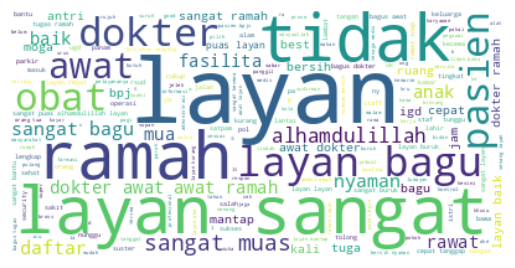

In [ ]:
teks_string = datas['review'].dropna(ignore_index=True).to_string()

wordcloud = WordCloud(background_color="white")
wordcloud.generate(teks_string)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
def preprocessor2(text):
  steps = {}
  steps['Raw'] = text

  text = text.lower() # Case Folding
  steps['Case Folding'] = text
  text = remove_emoji(text) # Remove Emoji
  steps['Remove Emoji'] = text
  text = re.sub(r"[0-9]|[^\w\s]|_", " ", text) # Remove Number & Punct
  steps['Remove Number & Punct'] = text
  text = " ".join(text.split()) # Remove Whitespace
  steps['Remove Whitespace'] = text
  text = re.sub("(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)", " ", text) # Remove Single Char
  steps['Remove Single Char'] = text
  text = change(text) # Text Normalization
  steps['Text Normalization'] = text
  text = nltk.word_tokenize(text) # Tokenize
  steps['Tokenize'] = text
  text = [w for w in text if w not in sw_list] # Remove Stopwords
  steps['Remove Stopwords'] = text
  text = " ".join(text)
  text = stemmer.stem(text) # Stemming
  steps['Stemming'] = text

  return steps

In [ ]:
datas = pd.read_excel('/content/Labeled Dataset.xlsx')

results=[]
for i in datas['review'][:10]:
  result = preprocessor2(i)
  results.append(result)

In [ ]:
pd.DataFrame(results)

,Raw,Case Folding,Remove Emoji,Remove Number & Punct,Remove Whitespace,Remove Single Char,Text Normalization,Tokenize,Remove Stopwords,Stemming
0,"Pelayanannya mantap 👍Dokter, perawat & petugas...","pelayanannya mantap 👍dokter, perawat & petugas...","pelayanannya mantap dokter, perawat & petugas...",pelayanannya mantap dokter perawat petugas...,pelayanannya mantap dokter perawat petugasnya ...,pelayanannya mantap dokter perawat petugasnya ...,pelayanannya mantap dokter perawat petugasnya ...,"[pelayanannya, mantap, dokter, perawat, petuga...","[pelayanannya, mantap, dokter, perawat, petuga...",layan mantap dokter awat tugas sangat sangat r...
1,"Seharusnya pelayanan bisa lebih baik, hanya sa...","seharusnya pelayanan bisa lebih baik, hanya sa...","seharusnya pelayanan bisa lebih baik, hanya sa...",seharusnya pelayanan bisa lebih baik hanya sa...,seharusnya pelayanan bisa lebih baik hanya saj...,seharusnya pelayanan bisa lebih baik hanya saj...,seharusnya pelayanan bisa lebih baik hanya saj...,"[seharusnya, pelayanan, bisa, lebih, baik, han...","[pelayanan, malam, senin, tanggal, penimbangan...",layan malam senin tanggal timbang bayi cek bay...
2,"Selalu puas sama pelayanan di annisa, dari keh...","selalu puas sama pelayanan di annisa, dari keh...","selalu puas sama pelayanan di annisa, dari keh...",selalu puas sama pelayanan di annisa dari keh...,selalu puas sama pelayanan di annisa dari keha...,selalu puas sama pelayanan di annisa dari keha...,selalu puas sama pelayanan di annisa dari keha...,"[selalu, puas, sama, pelayanan, di, annisa, da...","[puas, pelayanan, kehamilan, kehamilan, kontro...",puas layan hamil hamil kontrol diannisa staf b...
3,RSIA anissa tempat berobat dan persalinan yang...,rsia anissa tempat berobat dan persalinan yang...,rsia anissa tempat berobat dan persalinan yang...,rsia anissa tempat berobat dan persalinan yang...,rsia anissa tempat berobat dan persalinan yang...,rsia anissa tempat berobat dan persalinan yang...,rsia anissa tempat berobat dan persalinan yang...,"[rsia, anissa, tempat, berobat, dan, persalina...","[berobat, persalinan, sangat, mantab, karyawan...",obat salin sangat mantab karyawan ramah tidak ...
4,RS yang sangat2 gercep melakukan tindakan tida...,rs yang sangat2 gercep melakukan tindakan tida...,rs yang sangat2 gercep melakukan tindakan tida...,rs yang sangat gercep melakukan tindakan tida...,rs yang sangat gercep melakukan tindakan tidak...,rs yang sangat gercep melakukan tindakan tidak...,rs yang sangat gercep melakukan tindakan tidak...,"[rs, yang, sangat, gercep, melakukan, tindakan...","[sangat, gercep, tindakan, tidak, pakai, nungg...",sangat gercep tindak tidak pakai nunggu moga n...
5,Masya AllahTabarakallahJazakumullah KhoironSan...,masya allahtabarakallahjazakumullah khoironsan...,masya allahtabarakallahjazakumullah khoironsan...,masya allahtabarakallahjazakumullah khoironsan...,masya allahtabarakallahjazakumullah khoironsan...,masya allahtabarakallahjazakumullah khoironsan...,masya allahtabarakallahjazakumullah khoironsan...,"[masya, allahtabarakallahjazakumullah, khoiron...","[masya, allahtabarakallahjazakumullah, khoiron...",masya allahtabarakallahjazakumullah khoironsan...
6,Alhamdulillah selalu percaya dengan RSIA Annis...,alhamdulillah selalu percaya dengan rsia annis...,alhamdulillah selalu percaya dengan rsia annis...,alhamdulillah selalu percaya dengan rsia annis...,alhamdulillah selalu percaya dengan rsia annis...,alhamdulillah selalu percaya dengan rsia annis...,alhamdulillah selalu percaya dengan rsia annis...,"[alhamdulillah, selalu, percaya, dengan, rsia,...","[alhamdulillah, percaya, lahiran, ketiga, seti...",alhamdulillah percaya lahir tiga setia layan b...
7,Alhamdulillaah sudah 2 kali lahiran di annisaM...,alhamdulillaah sudah 2 kali lahiran di annisam...,alhamdulillaah sudah 2 kali lahiran di annisam...,alhamdulillaah sudah kali lahiran di annisam...,alhamdulillaah sudah kali lahiran di annisamaa...,alhamdulillaah sudah kali lahiran di annisamaa...,alha

# Topic Modeling

In [ ]:
datas = pd.read_excel('/content/Cleaned Data.xlsx')
datas = datas.dropna(subset='review')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
datas['label'].isna().sum()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


109

In [ ]:
# Tokenisasi
import nltk
token_list = []

for i in datas['review']:
  indeks = nltk.word_tokenize(i)
  token_list.append(indeks)

In [ ]:
# Membangun dictionary
dictionary = corpora.Dictionary(token_list)
dictionary.filter_extremes(no_below=10, no_above=0.4)

In [ ]:
# Membangun model TF-IDF
doc_term_matrix = [dictionary.doc2bow(doc) for doc in token_list]
tfidf = TfidfModel(doc_term_matrix)
corpus_tfidf = tfidf[doc_term_matrix]

In [ ]:
from gensim.models import CoherenceModel
import gensim

def lda(dictionary, corpus, texts, limit, start, step): # fungsi melatih model LDA dan menghitung coherence score
    coherence_values = []
    model_list = []
    perplexity_values = []

    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       passes=10,
                                       iterations=100,
                                       random_state=417)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        model_list.append(model)
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(corpus))

    return model_list, coherence_values, perplexity_values

In [ ]:
start=1
limit=11
step=1

model_list, coherence_values, perplexity_values = lda(dictionary,
                                                      corpus=corpus_tfidf,
                                                      texts=token_list,
                                                      start=start,
                                                      limit=limit,
                                                      step=step)

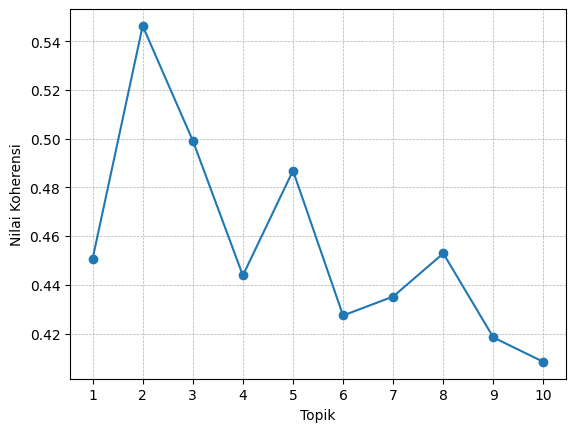

In [ ]:
# visualisasi chart coherence score
import matplotlib.pyplot as plt

x = range(start, limit, step)
plt.plot(x, coherence_values, marker='o')
plt.xlabel('Topik')
plt.ylabel('Nilai Koherensi')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

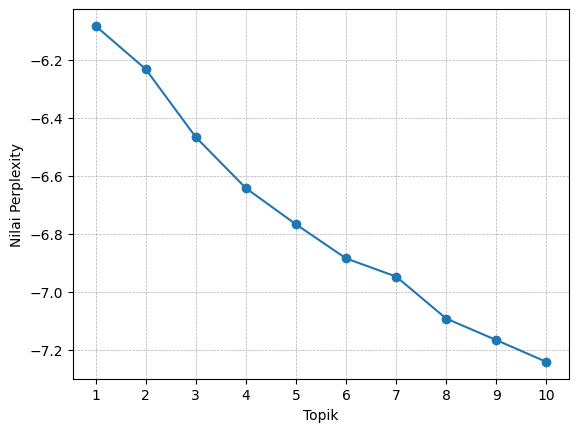

In [ ]:
# visualisasi chart coherence score -- TIDAK DIGUNAKAN

x = range(start, limit, step)
plt.plot(x, perplexity_values, marker='o')
plt.xlabel('Topik')
plt.ylabel('Nilai Perplexity')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

In [ ]:
pd.DataFrame([x, coherence_values, perplexity_values], index=['Jumlah Topik', 'Coherence Value', 'Perplexity Value']).transpose()

,Jumlah Topik,Coherence Value,Perplexity Value
0,1.0,0.450624,-6.083588
1,2.0,0.546239,-6.232443
2,3.0,0.499201,-6.466962
3,4.0,0.443843,-6.642799
4,5.0,0.486844,-6.767626
5,6.0,0.427407,-6.885048
6,7.0,0.435185,-6.947796
7,8.0,0.452900,-7.092624
8,9.0,0.418398,-7.166639
9,10.0,0.408356,-7.241924


## LDAVIS

In [ ]:
import pyLDAvis.gensim
import pyLDAvis

pyLDAvis.enable_notebook()

model = model_list[2]
lda_vis_data = pyLDAvis.gensim.prepare(model, corpus_tfidf, dictionary)
pyLDAvis.save_html(lda_vis_data, '/content/Visualisasi LDA.html')

In [ ]:
pyLDAvis.display(lda_vis_data)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pd.DataFrame(model_list[2].print_topics(), columns=['Topik', 'Probabilitas Kata'])

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topik,Probabilitas Kata
0,0,"0.027*""baik"" + 0.023*""daftar"" + 0.022*""jam"" + ..."
1,1,"0.059*""sangat"" + 0.055*""bagus"" + 0.052*""ramah""..."
2,2,"0.033*""tidak"" + 0.021*""bpjs"" + 0.017*""pasien"" ..."


## Label Topik

In [ ]:
topic_labels = {
    0: "administrasi",
    1: "pelayanan",
    2: "administrasi"
}

def get_document_topic(lda_model, corpus, topic_labels):
    document_topics = []
    for doc in corpus:
        topic_distribution = lda_model.get_document_topics(doc)
        dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
        document_topics.append(topic_labels[dominant_topic])
    return document_topics

document_topics = get_document_topic(model_list[2], corpus_tfidf, topic_labels)
datas['topic'] = document_topics
datas.to_excel('Topic Dataset.xlsx', index=False)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
datas['topic'].value_counts()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
topic,
administrasi,2771
pelayanan,2294


In [ ]:
datas['label'][datas['topic'] == 'administrasi'].value_counts()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
label,
negatif,1408
positif,1284


In [ ]:
datas['label'][datas['topic'] == 'pelayanan'].value_counts()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
label,
positif,2221
negatif,43


# Aspect-Based Sentiment Analysis

In [ ]:
# Membaca data
datas = pd.read_excel('/content/Topic Dataset.xlsx')
datas = datas.dropna(subset='label').reset_index(drop=True)

## Pipeline

In [ ]:
import matplotlib.ticker as ticker

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=417) # KFOLD
smote = SMOTE(random_state=417) # SMOTE

classifiers = [ # seluruh model yg digunakan
    ('Naive Bayes', naive_bayes.MultinomialNB()),
    ('k=3', KNeighborsClassifier(n_neighbors=3)),
    ('k=5', KNeighborsClassifier(n_neighbors=5)),
    ('k=7', KNeighborsClassifier(n_neighbors=7)),
    ('k=9', KNeighborsClassifier(n_neighbors=9)),
]

pipelines = [(name, imb_Pipeline([ # membuat pipeline
      ('smote', smote),
      ('clf', clf)
      ])) for name, clf in classifiers]

## Klasifikasi Aspek

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,3))
X_aspek = vectorizer.fit_transform(datas['review']) # TFIDF

In [ ]:
result = {}

for name, pipeline in pipelines:
  result[name] = {
      'cm' : [],
      'cr' : [],
      'cr2' : [],
  }

  # proses split data oleh kfold dan pelatihan model
  for train_index, test_index in kf.split(X_aspek, datas['topic']):
    x_train, x_test = X_aspek[train_index], X_aspek[test_index]
    y_train, y_test = datas['topic'][train_index], datas['topic'][test_index]

    model_fit = pipeline.fit(x_train, y_train)
    labels = model_fit.predict(x_test)
    cm = confusion_matrix(y_test, labels)
    cr = classification_report(y_test, labels, output_dict=True)
    cr2 = classification_report(y_test, labels)

    result[name]['cm'].append(cm)
    result[name]['cr'].append(cr)
    result[name]['cr2'].append(cr2)

### Confusion Matrix

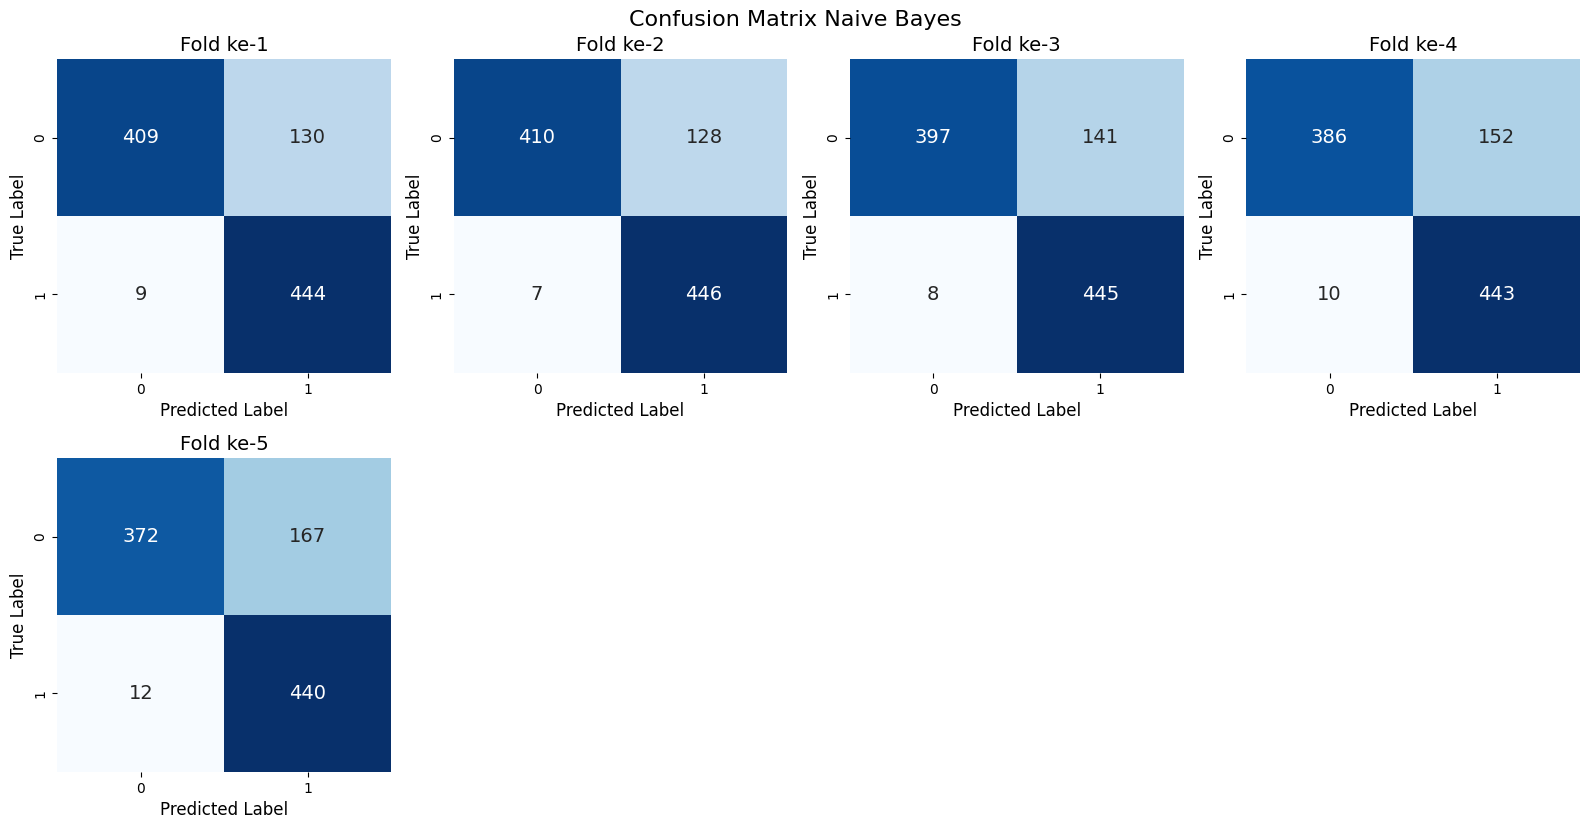

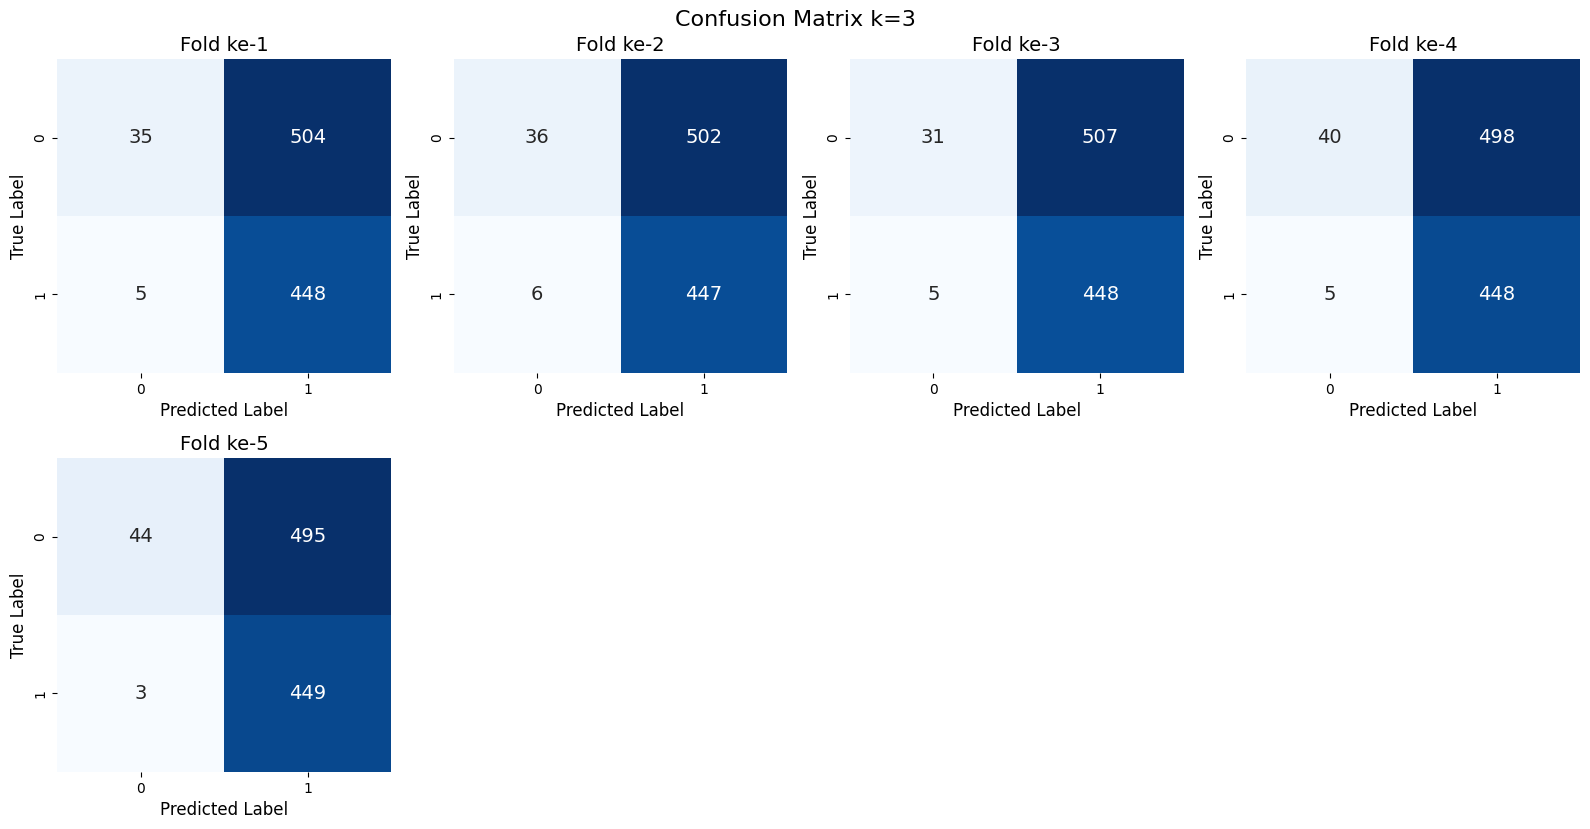

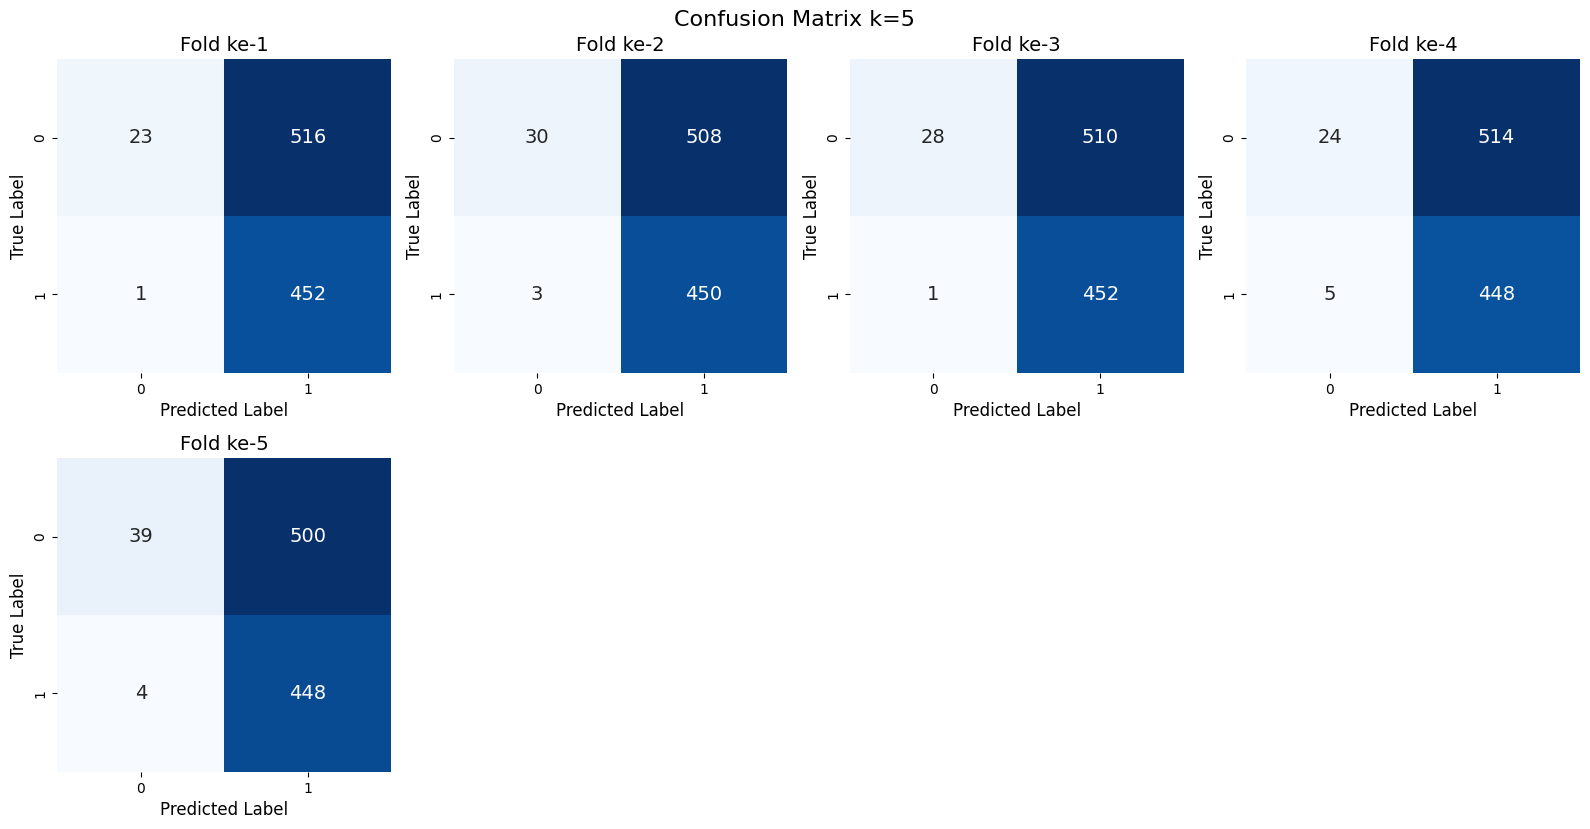

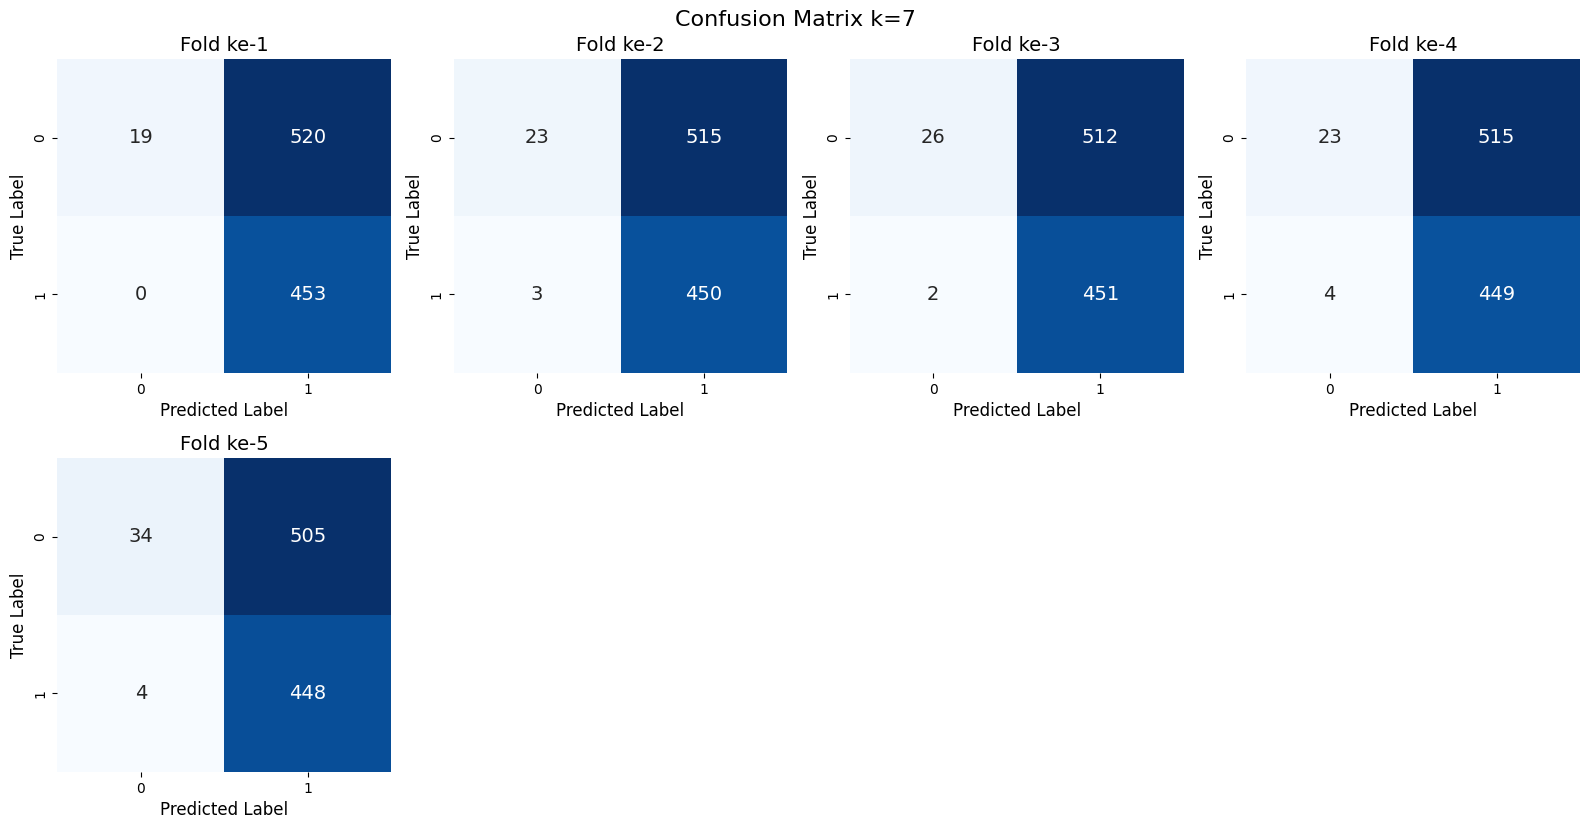

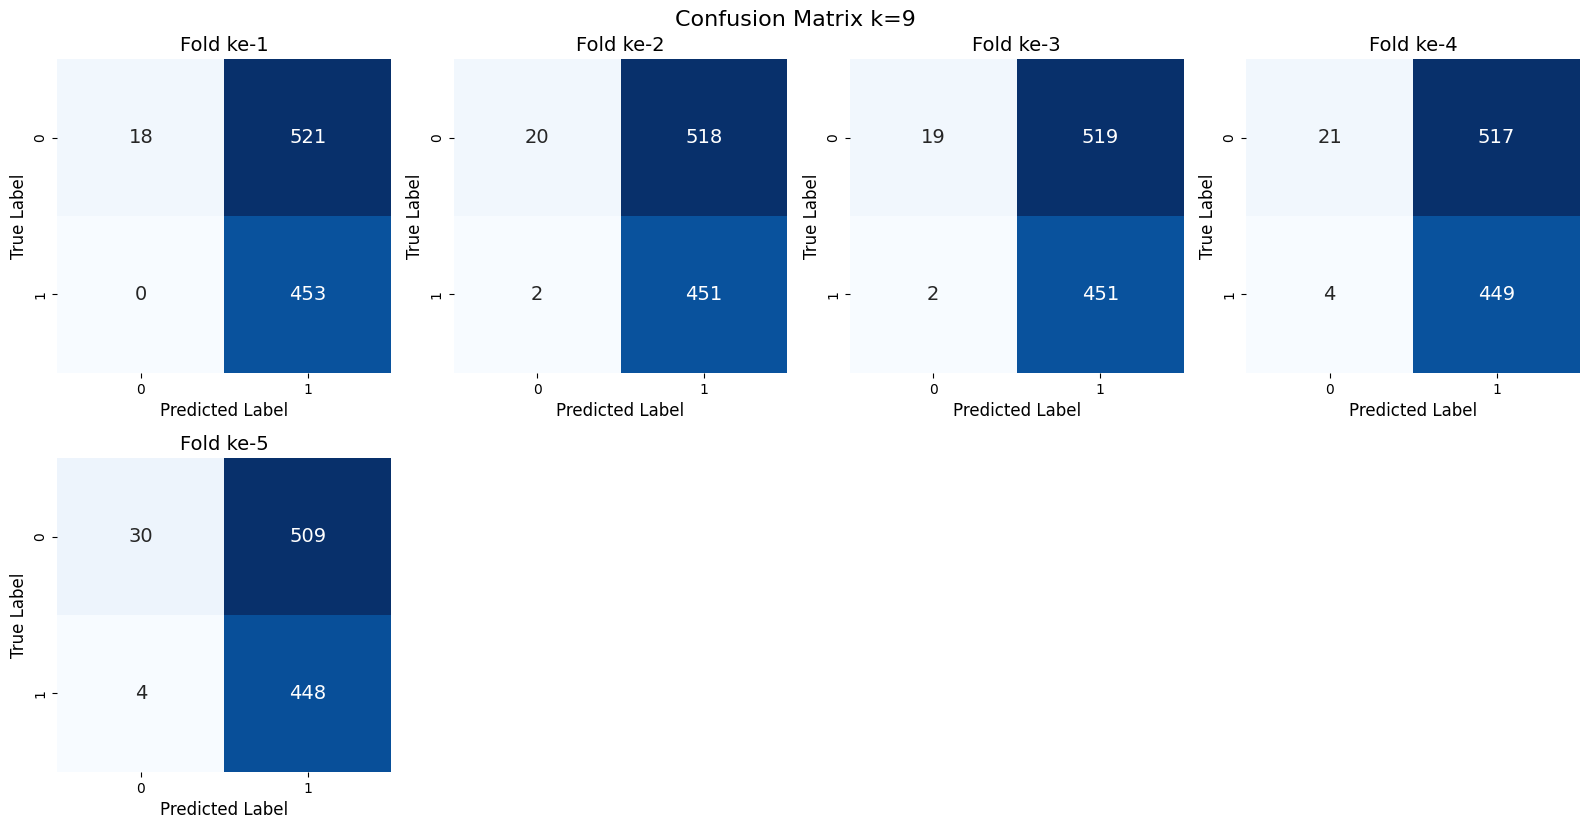

In [ ]:
for name, metrik in result.items():
  fig, axes = plt.subplots(3, 4, figsize=(16, 12))
  axes = axes.flatten()
  for idx, cm in enumerate(metrik['cm']):
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='g', cbar=False, ax=ax, cmap='Blues', annot_kws={"size": 14})
    ax.set_title(f"Fold ke-{idx+1}", fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
  for i in range(len(metrik['cm']), len(axes)):
    fig.delaxes(axes[i])
  fig.suptitle(f"Confusion Matrix {name}", size=16)
  plt.tight_layout()
  plt.show()
  print('\n')

### Akurasi

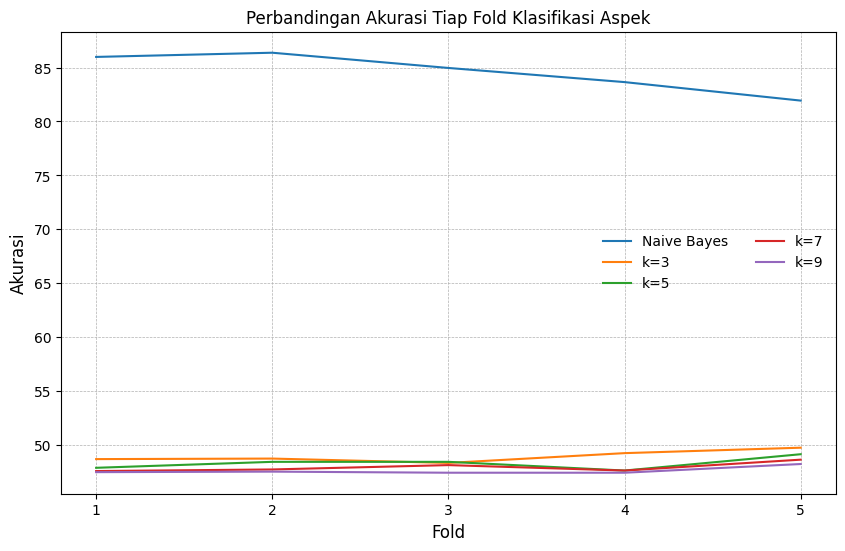

In [ ]:
acc = {name: [cr['accuracy'] for cr in metrik['cr']] for name, metrik in result.items()}

plt.figure(figsize=(10, 6))
for name, akurasi in acc.items():
  plt.plot(range(1,6), [x*100 for x in akurasi], label=name)
plt.title('Perbandingan Akurasi Tiap Fold Klasifikasi Aspek')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Akurasi', fontsize=12)
plt.legend(ncol=2, frameon=False)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

In [ ]:
pd.concat([
    pd.DataFrame(acc, index=[f'{i}' for i in range(1,6)]).applymap(lambda x: f'{x * 100:.1f}%'),
    pd.DataFrame([[sum(acc[i])/5 for i in acc]], columns=[i for i in acc], index=['Mean']).applymap(lambda x: f'{x * 100:.1f}%')
    ]).transpose()

,1,2,3,4,5,Mean
Naive Bayes,86.0%,86.4%,85.0%,83.7%,81.9%,84.6%
k=3,48.7%,48.7%,48.3%,49.2%,49.7%,49.0%
k=5,47.9%,48.4%,48.4%,47.6%,49.1%,48.3%
k=7,47.6%,47.7%,48.1%,47.6%,48.6%,47.9%
k=9,47.5%,47.5%,47.4%,47.4%,48.2%,47.6%


### Classification Report

In [ ]:
for i in result['Naive Bayes']['cr2']:
  print(i)
  print()

              precision    recall  f1-score   support

administrasi       0.98      0.76      0.85       539
   pelayanan       0.77      0.98      0.86       453

    accuracy                           0.86       992
   macro avg       0.88      0.87      0.86       992
weighted avg       0.88      0.86      0.86       992


              precision    recall  f1-score   support

administrasi       0.98      0.76      0.86       538
   pelayanan       0.78      0.98      0.87       453

    accuracy                           0.86       991
   macro avg       0.88      0.87      0.86       991
weighted avg       0.89      0.86      0.86       991


              precision    recall  f1-score   support

administrasi       0.98      0.74      0.84       538
   pelayanan       0.76      0.98      0.86       453

    accuracy                           0.85       991
   macro avg       0.87      0.86      0.85       991
weighted avg       0.88      0.85      0.85       991


              pr

## Administrasi

In [ ]:
administrasi = datas[datas['topic'] == 'administrasi'].reset_index(drop=True)
vectorizer = TfidfVectorizer(ngram_range=(1,3))
X_tfidf = vectorizer.fit_transform(administrasi['review']) # TFIDF

In [ ]:
result = {}

for name, pipeline in pipelines:
  result[name] = {
      'cm' : [],
      'cr' : [],
      'cr2': []
  }

  # proses split data oleh kfold dan pelatihan model
  for train_index, test_index in kf.split(X_tfidf, administrasi['label']):
    x_train, x_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = administrasi['label'][train_index], administrasi['label'][test_index]

    model_fit = pipeline.fit(x_train, y_train)
    labels = model_fit.predict(x_test)
    cm = confusion_matrix(y_test, labels)
    cr = classification_report(y_test, labels, output_dict=True)
    cr2 = classification_report(y_test, labels)

    result[name]['cm'].append(cm)
    result[name]['cr'].append(cr)
    result[name]['cr2'].append(cr2)

### Confusion Matrix

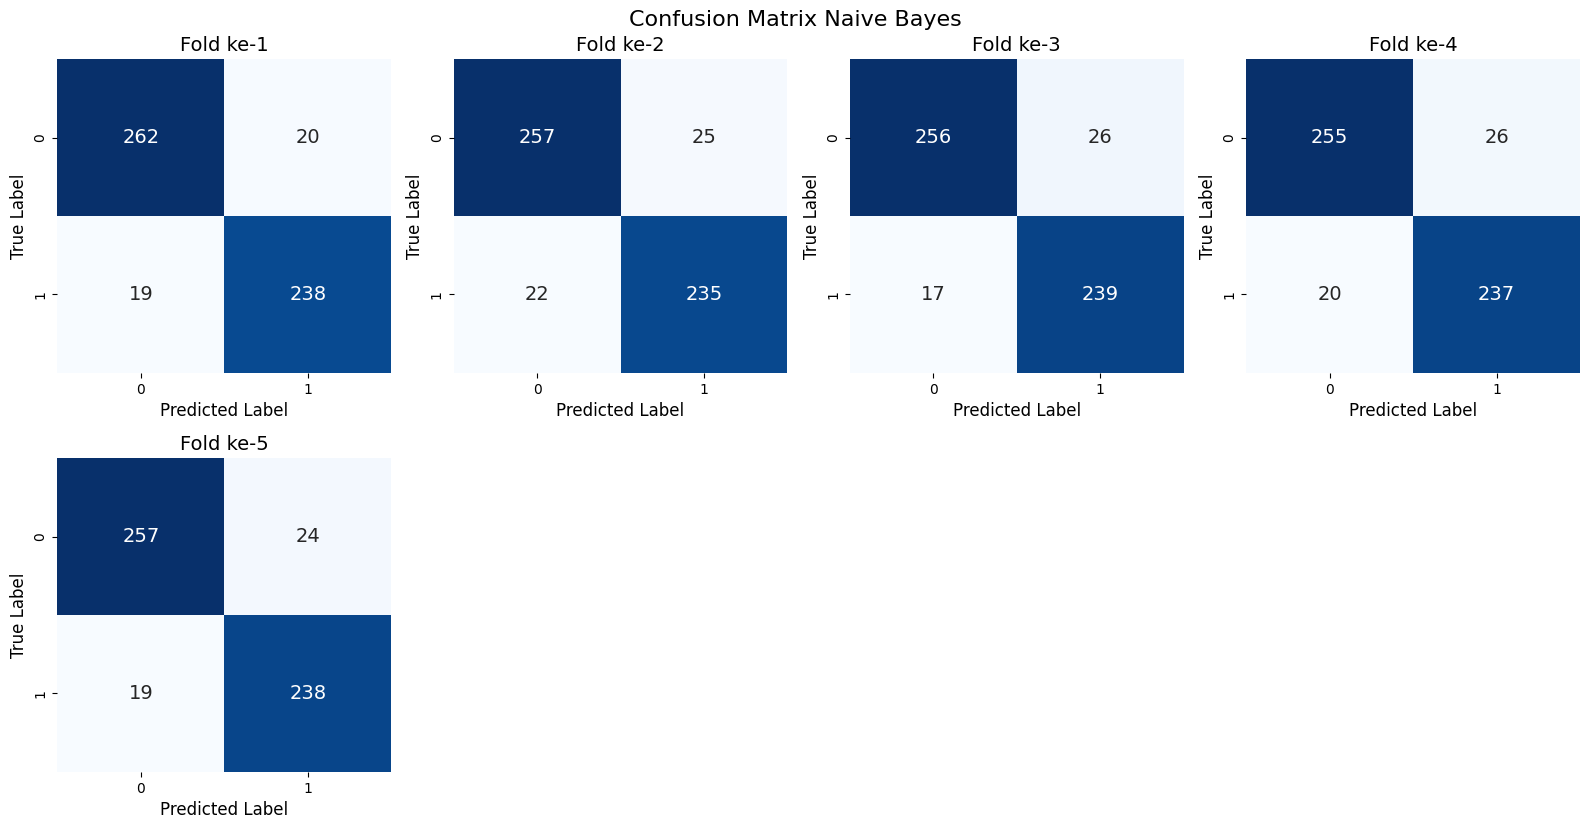

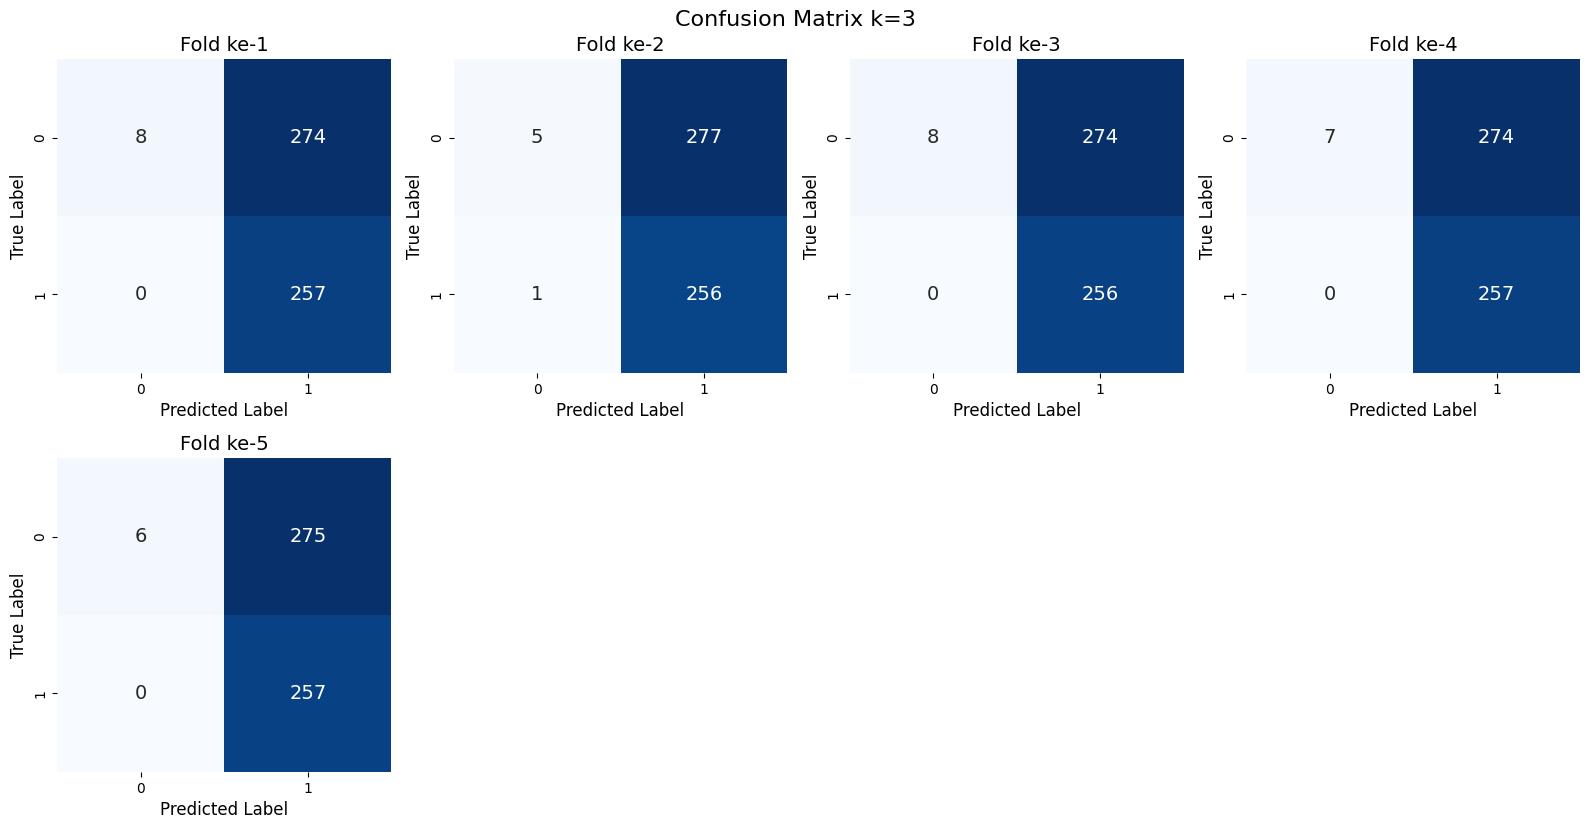

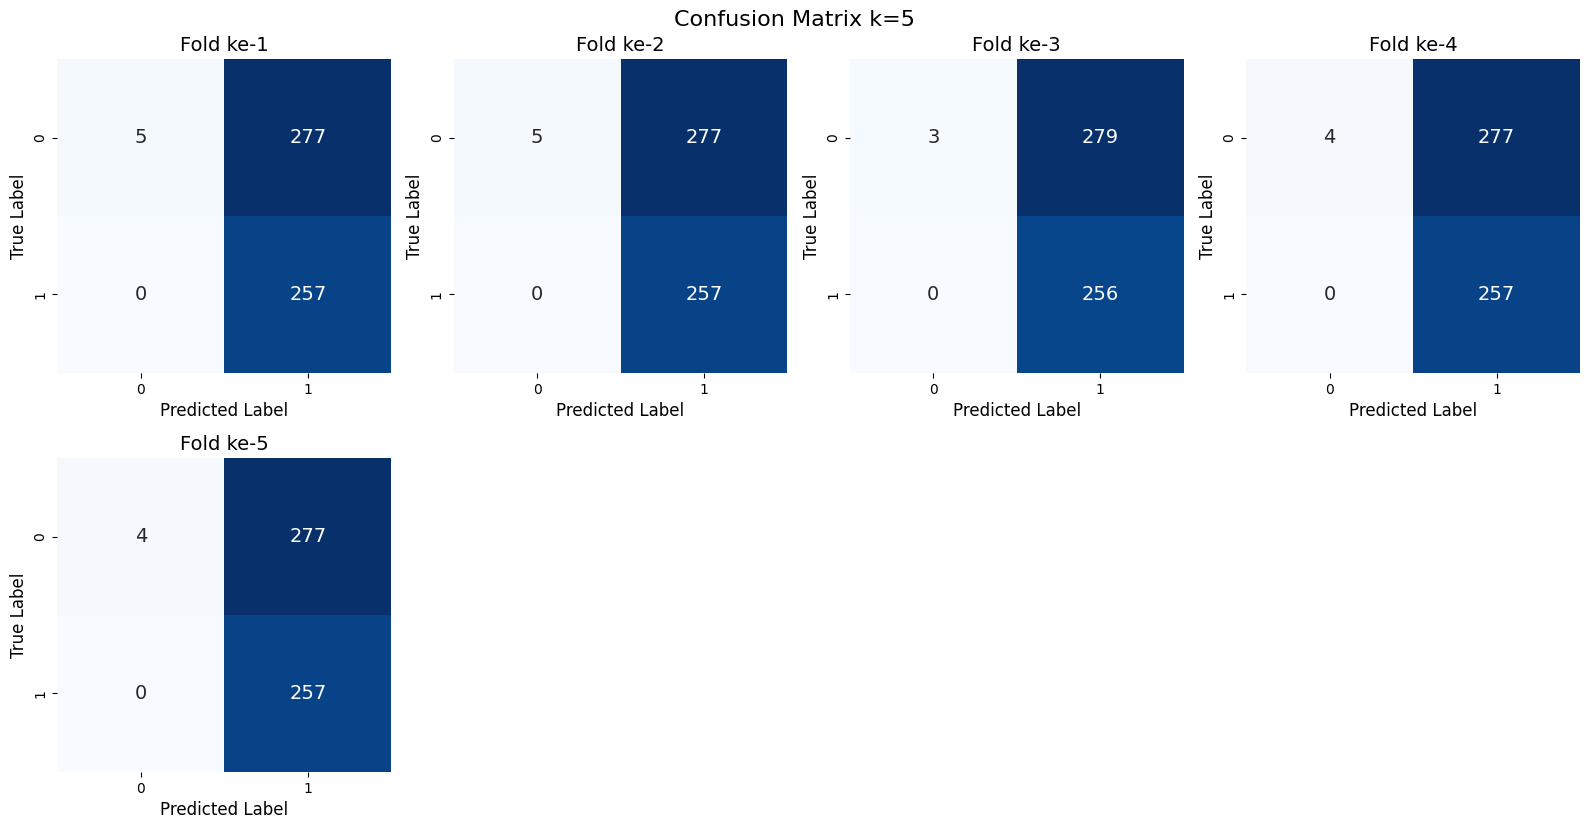

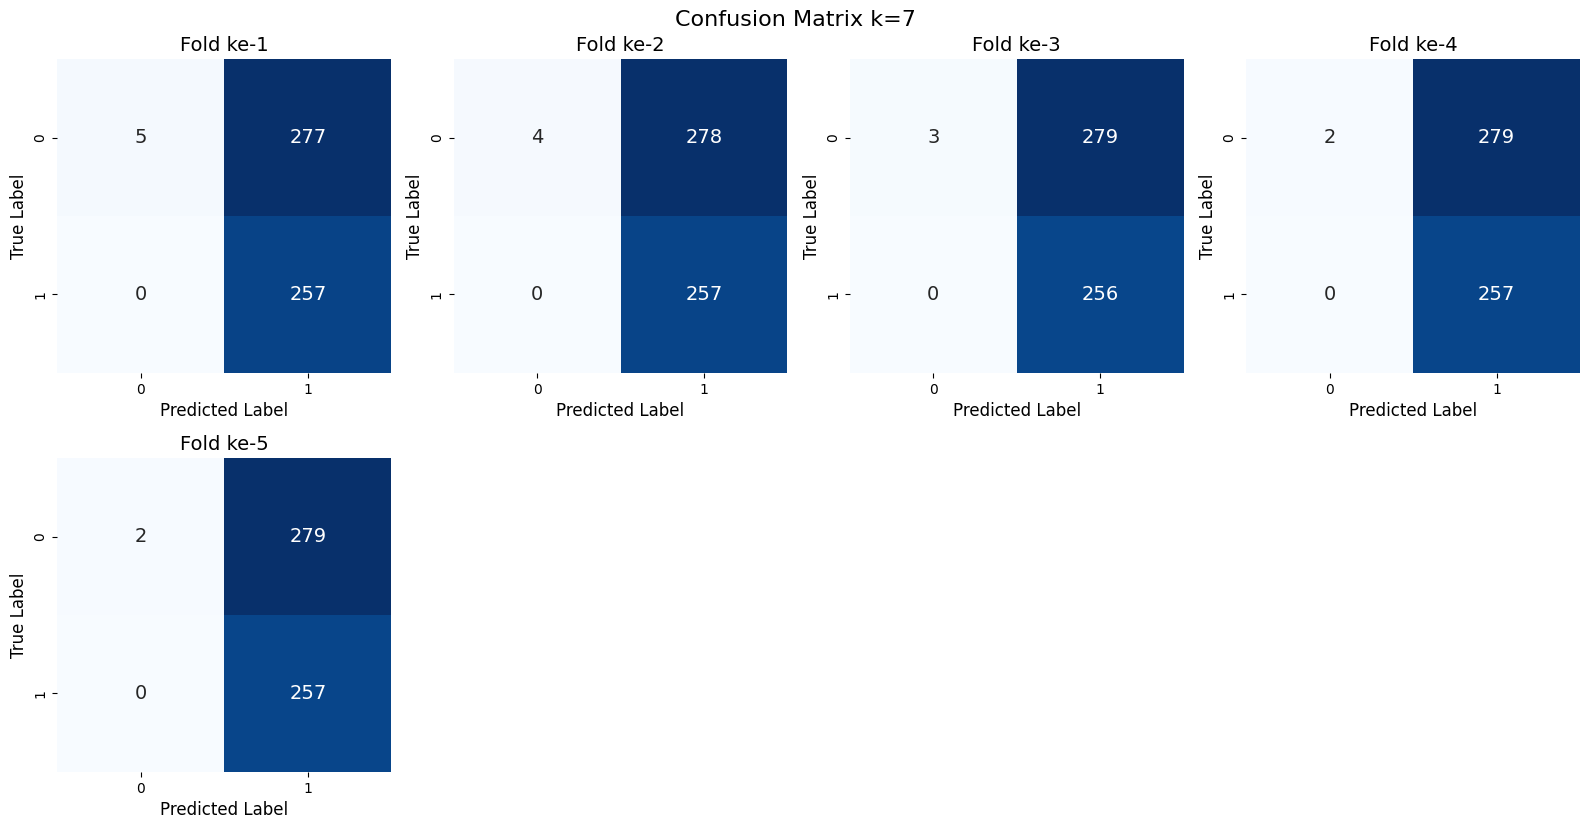

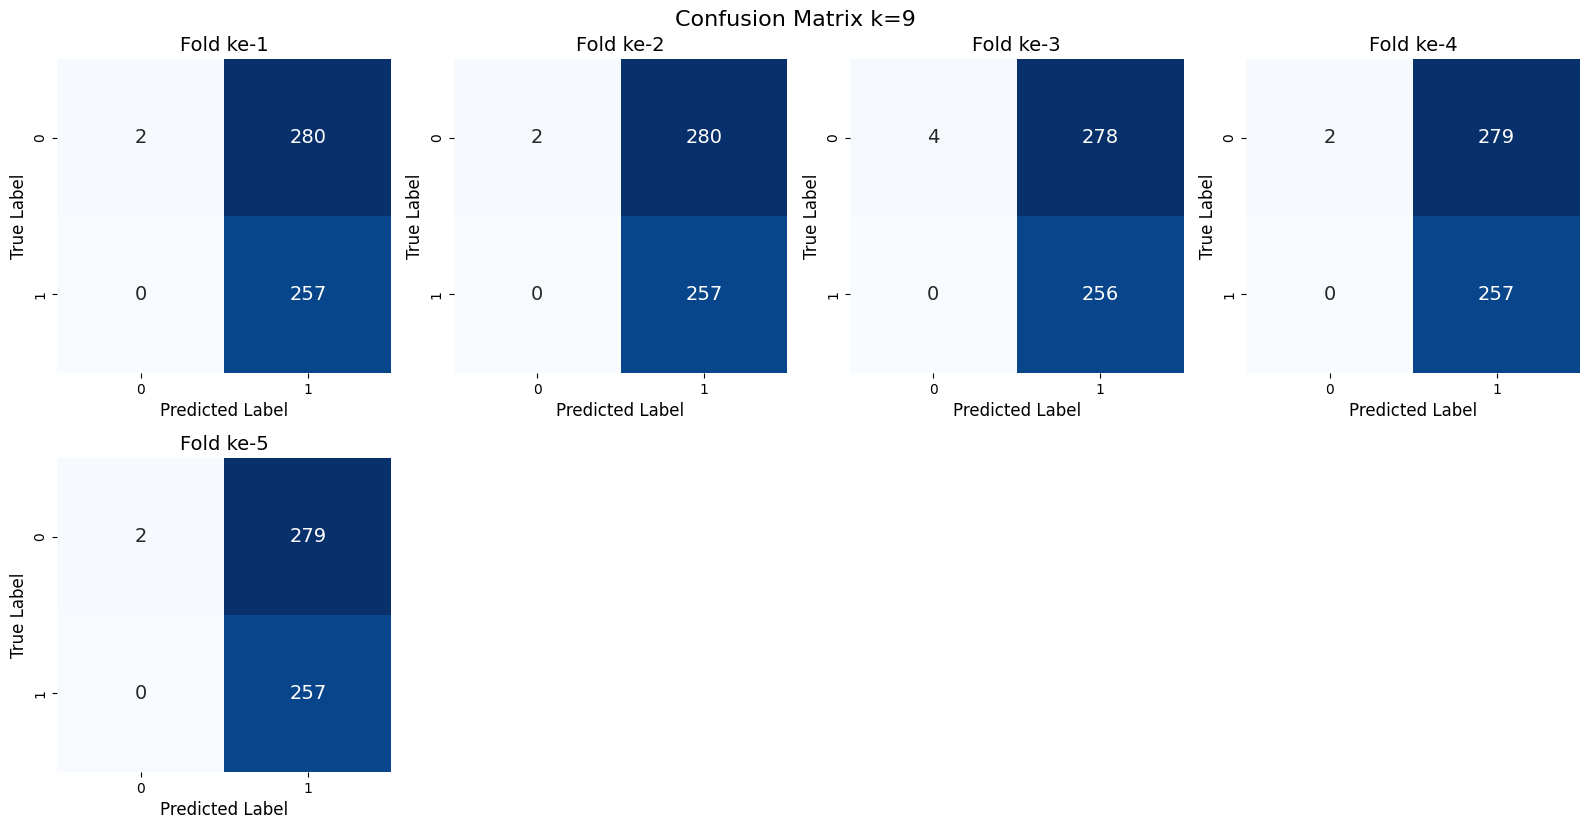

In [ ]:
for name, metrik in result.items():
  fig, axes = plt.subplots(3, 4, figsize=(16, 12))
  axes = axes.flatten()
  for idx, cm in enumerate(metrik['cm']):
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='g', cbar=False, ax=ax, cmap='Blues', annot_kws={"size": 14})
    ax.set_title(f"Fold ke-{idx+1}", fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
  for i in range(len(metrik['cm']), len(axes)):
    fig.delaxes(axes[i])
  fig.suptitle(f"Confusion Matrix {name}", size=16)
  plt.tight_layout()
  plt.show()
  print('\n')

### Akurasi

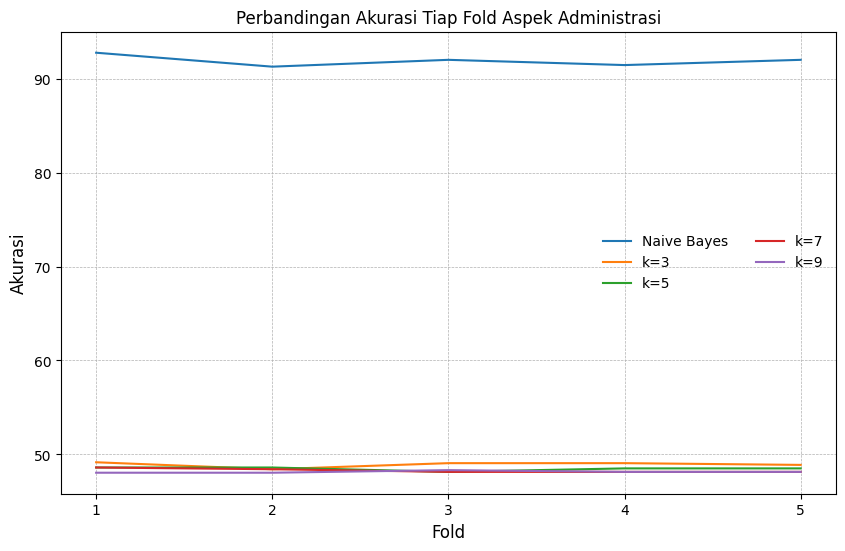

In [ ]:
acc = {name: [cr['accuracy'] for cr in metrik['cr']] for name, metrik in result.items()}

plt.figure(figsize=(10, 6))
for name, akurasi in acc.items():
  plt.plot(range(1,6), [x*100 for x in akurasi], label=name)
plt.title('Perbandingan Akurasi Tiap Fold Aspek Administrasi')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Akurasi', fontsize=12)
plt.legend(ncol=2, frameon=False)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

In [ ]:
pd.concat([
    pd.DataFrame(acc, index=[f'{i}' for i in range(1,6)]).applymap(lambda x: f'{x * 100:.1f}%'),
    pd.DataFrame([[sum(acc[i])/5 for i in acc]], columns=[i for i in acc], index=['Mean']).applymap(lambda x: f'{x * 100:.1f}%')
    ]).transpose()

,1,2,3,4,5,Mean
Naive Bayes,92.8%,91.3%,92.0%,91.4%,92.0%,91.9%
k=3,49.2%,48.4%,49.1%,49.1%,48.9%,48.9%
k=5,48.6%,48.6%,48.1%,48.5%,48.5%,48.5%
k=7,48.6%,48.4%,48.1%,48.1%,48.1%,48.3%
k=9,48.1%,48.1%,48.3%,48.1%,48.1%,48.1%


### Classification Report

In [ ]:
for i in result['Naive Bayes']['cr2']:
  print(i)
  print()

              precision    recall  f1-score   support

     negatif       0.93      0.93      0.93       282
     positif       0.92      0.93      0.92       257

    accuracy                           0.93       539
   macro avg       0.93      0.93      0.93       539
weighted avg       0.93      0.93      0.93       539


              precision    recall  f1-score   support

     negatif       0.92      0.91      0.92       282
     positif       0.90      0.91      0.91       257

    accuracy                           0.91       539
   macro avg       0.91      0.91      0.91       539
weighted avg       0.91      0.91      0.91       539


              precision    recall  f1-score   support

     negatif       0.94      0.91      0.92       282
     positif       0.90      0.93      0.92       256

    accuracy                           0.92       538
   macro avg       0.92      0.92      0.92       538
weighted avg       0.92      0.92      0.92       538


              pr

## Pelayanan

In [ ]:
pelayanan = datas[datas['topic'] == 'pelayanan'].reset_index(drop=True)
vectorizer = TfidfVectorizer(ngram_range=(1,3))
X_tfidf = vectorizer.fit_transform(pelayanan['review']) # TFIDF

In [ ]:
result = {}

for name, pipeline in pipelines:
  result[name] = {
      'cm' : [],
      'cr' : [],
      'cr2': []
  }

  # proses split data oleh kfold dan pelatihan model
  for train_index, test_index in kf.split(X_tfidf, pelayanan['label']):
    x_train, x_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = pelayanan['label'][train_index], pelayanan['label'][test_index]

    model_fit = pipeline.fit(x_train, y_train)
    labels = model_fit.predict(x_test)
    cm = confusion_matrix(y_test, labels)
    cr = classification_report(y_test, labels, output_dict=True)
    cr2 = classification_report(y_test, labels)

    result[name]['cm'].append(cm)
    result[name]['cr'].append(cr)
    result[name]['cr2'].append(cr2)

### Confusion Matrix

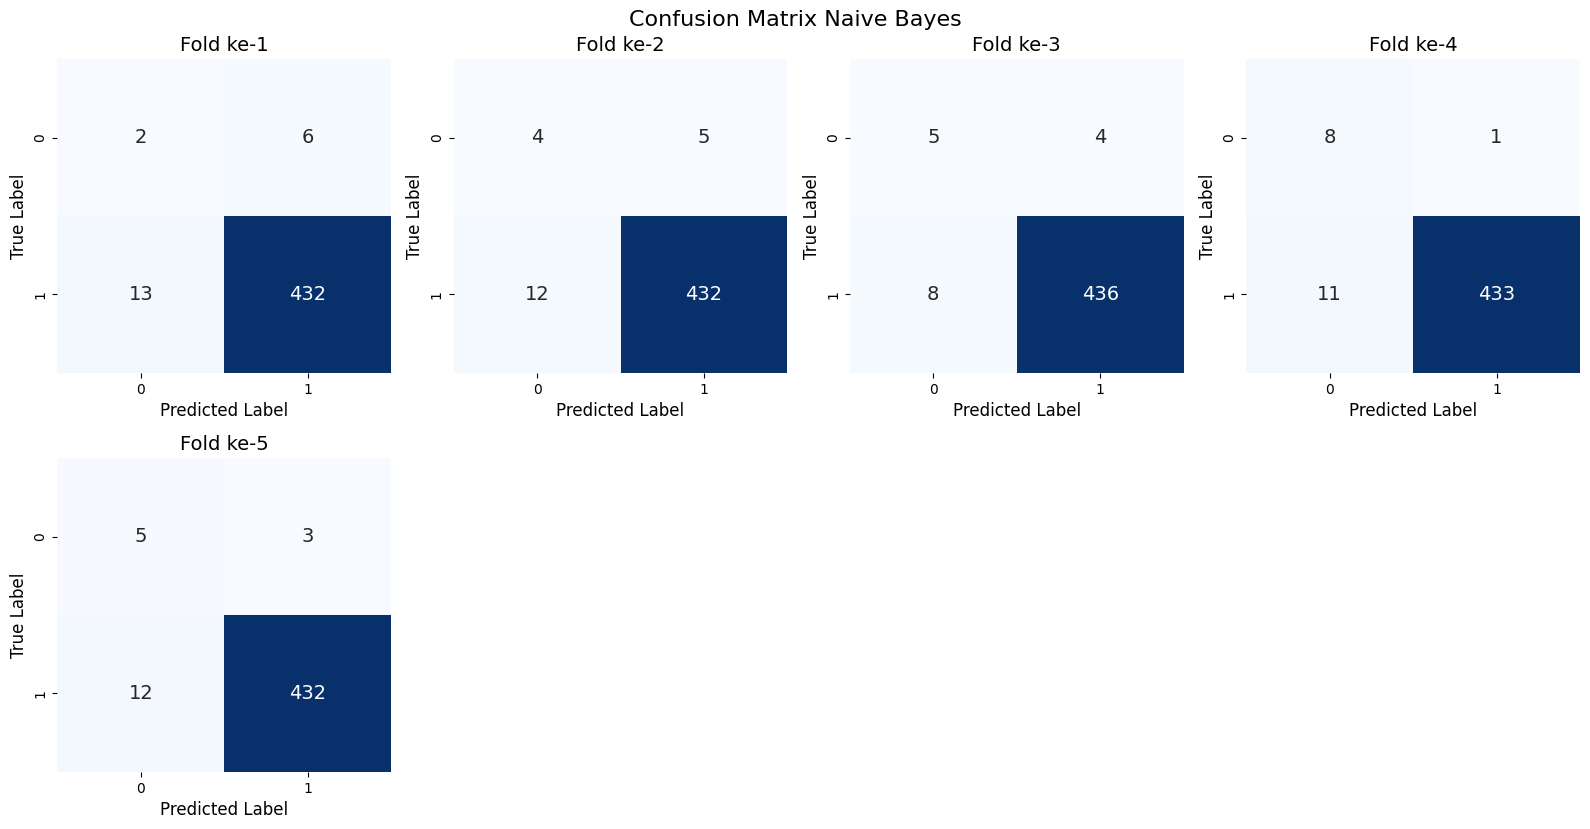

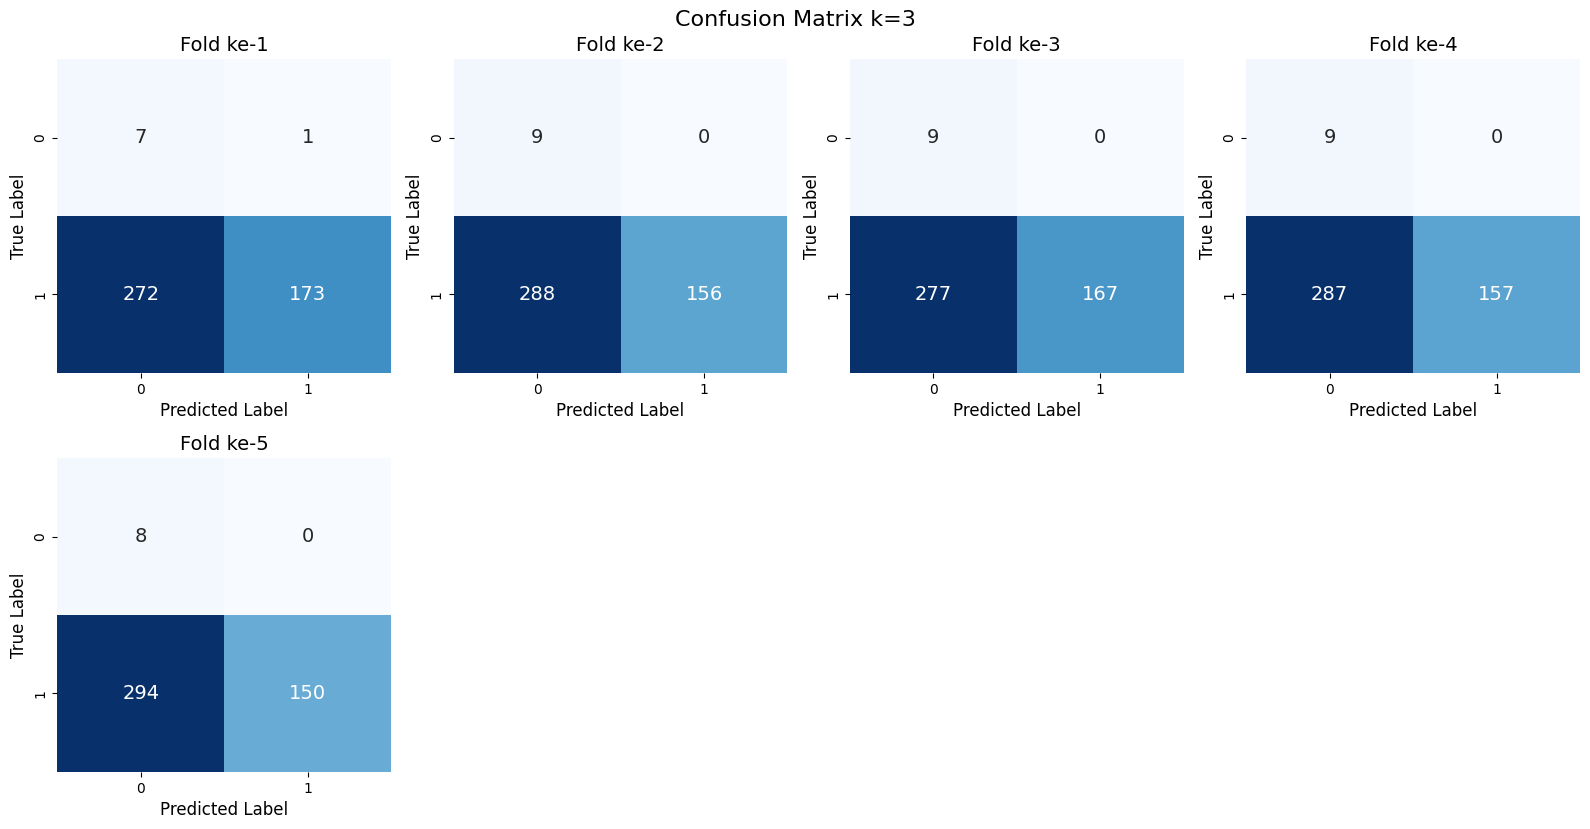

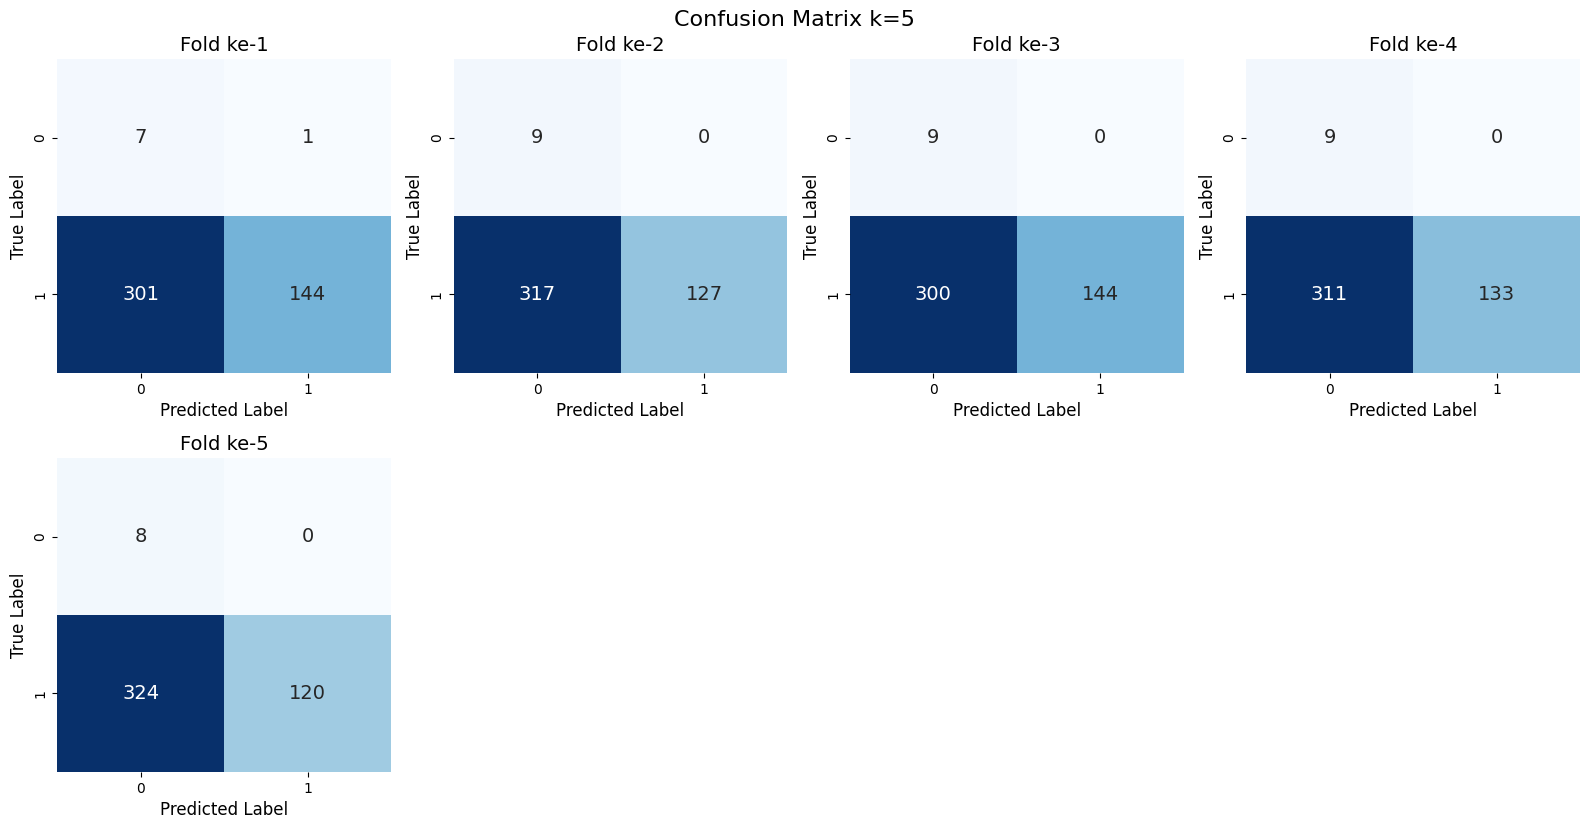

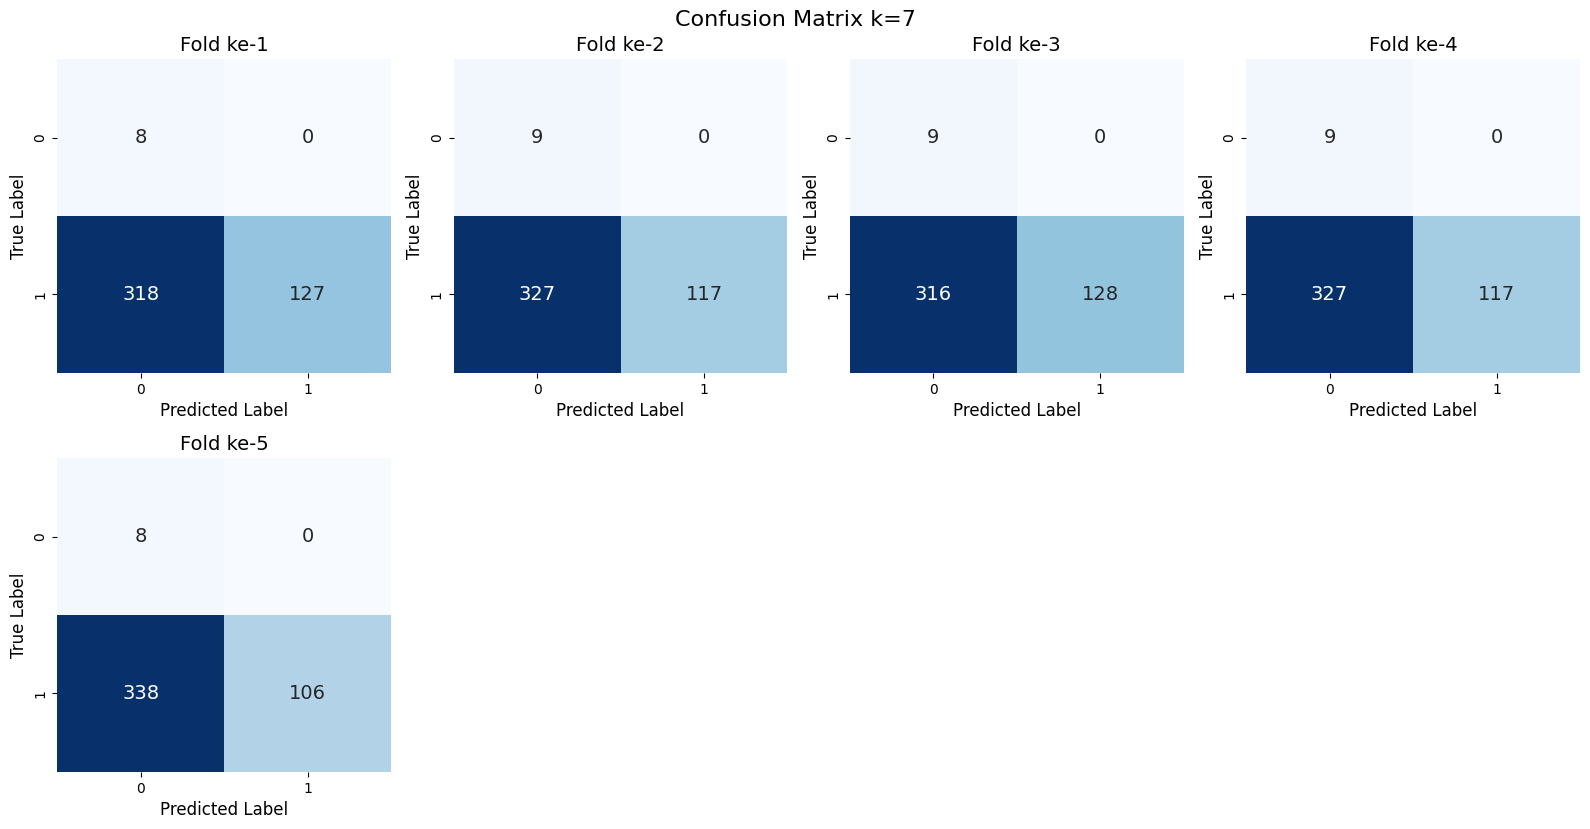

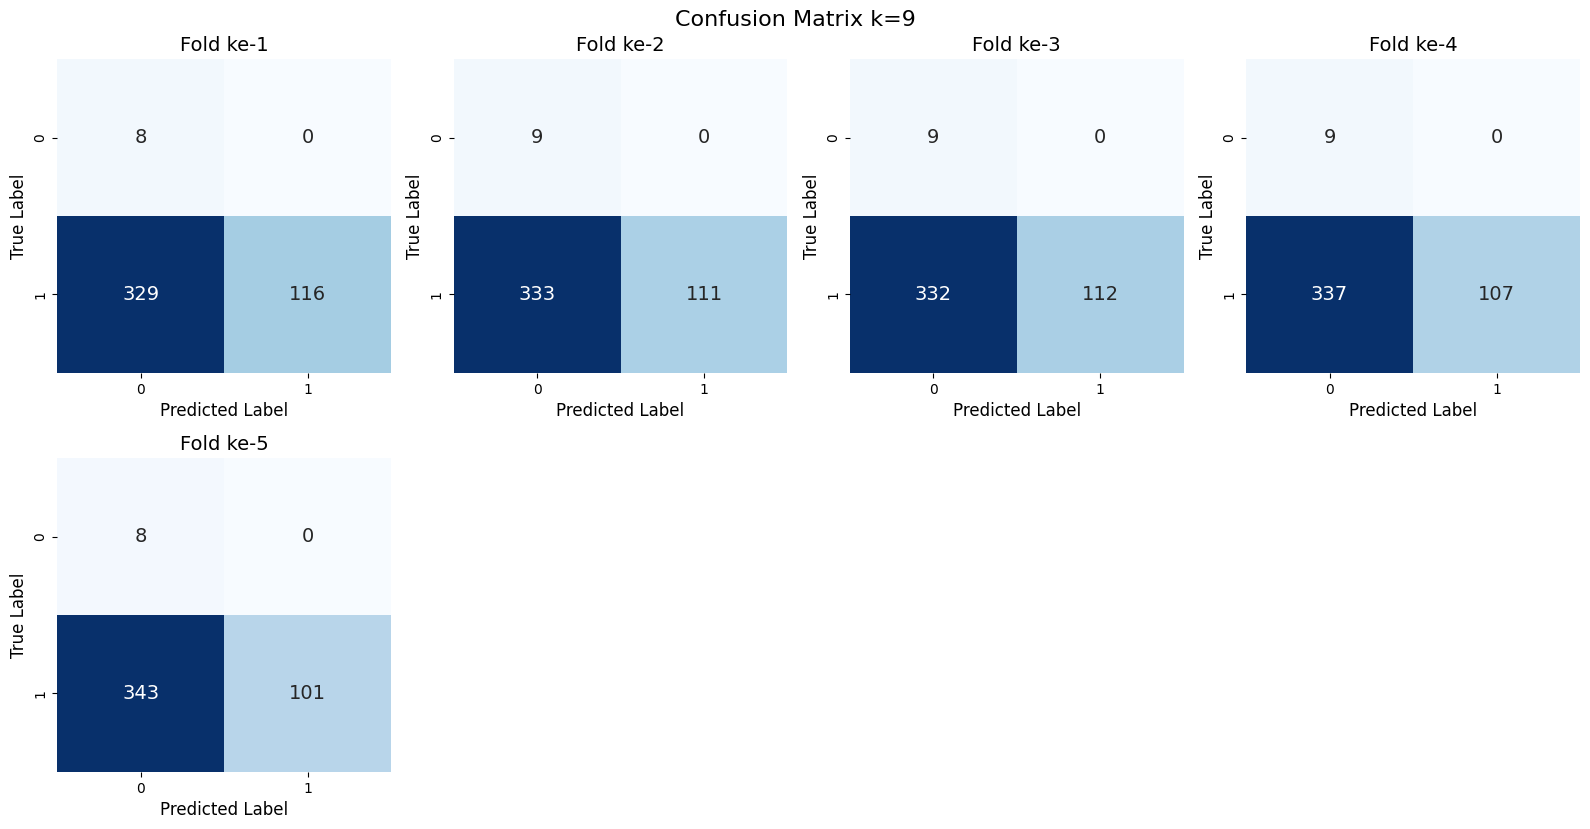

In [ ]:
for name, metrik in result.items():
  fig, axes = plt.subplots(3, 4, figsize=(16, 12))
  axes = axes.flatten()
  for idx, cm in enumerate(metrik['cm']):
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='g', cbar=False, ax=ax, cmap='Blues', annot_kws={"size": 14})
    ax.set_title(f"Fold ke-{idx+1}", fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
  for i in range(len(metrik['cm']), len(axes)):
    fig.delaxes(axes[i])
  fig.suptitle(f"Confusion Matrix {name}", size=16)
  plt.tight_layout()
  plt.show()
  print('\n')

### Akurasi

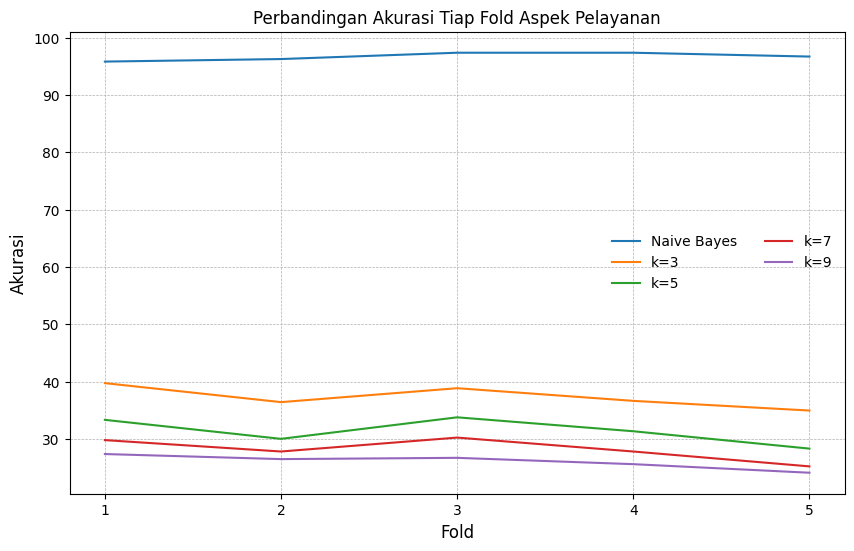

In [ ]:
acc = {name: [cr['accuracy'] for cr in metrik['cr']] for name, metrik in result.items()}

plt.figure(figsize=(10, 6))
for name, akurasi in acc.items():
  plt.plot(range(1,6), [x*100 for x in akurasi], label=name)
plt.title('Perbandingan Akurasi Tiap Fold Aspek Pelayanan')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Akurasi', fontsize=12)
plt.legend(ncol=2, frameon=False)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

In [ ]:
pd.concat([
    pd.DataFrame(acc, index=[f'{i}' for i in range(1,6)]).applymap(lambda x: f'{x * 100:.1f}%'),
    pd.DataFrame([[sum(acc[i])/5 for i in acc]], columns=[i for i in acc], index=['Mean']).applymap(lambda x: f'{x * 100:.1f}%')
    ]).transpose()

,1,2,3,4,5,Mean
Naive Bayes,95.8%,96.2%,97.4%,97.4%,96.7%,96.7%
k=3,39.7%,36.4%,38.9%,36.6%,35.0%,37.3%
k=5,33.3%,30.0%,33.8%,31.3%,28.3%,31.4%
k=7,29.8%,27.8%,30.2%,27.8%,25.2%,28.2%
k=9,27.4%,26.5%,26.7%,25.6%,24.1%,26.1%


### Classification Report

In [ ]:
for i in result['Naive Bayes']['cr2']:
  print(i)
  print()

              precision    recall  f1-score   support

     negatif       0.13      0.25      0.17         8
     positif       0.99      0.97      0.98       445

    accuracy                           0.96       453
   macro avg       0.56      0.61      0.58       453
weighted avg       0.97      0.96      0.96       453


              precision    recall  f1-score   support

     negatif       0.25      0.44      0.32         9
     positif       0.99      0.97      0.98       444

    accuracy                           0.96       453
   macro avg       0.62      0.71      0.65       453
weighted avg       0.97      0.96      0.97       453


              precision    recall  f1-score   support

     negatif       0.38      0.56      0.45         9
     positif       0.99      0.98      0.99       444

    accuracy                           0.97       453
   macro avg       0.69      0.77      0.72       453
weighted avg       0.98      0.97      0.98       453


              pr

# Perbandingan SMOTE Sebelum dan Sesudah KFold

In [ ]:
kf_sesudah = StratifiedKFold(n_splits=5, shuffle=True, random_state=478)
vectorizer_sesudah = TfidfVectorizer(ngram_range=(1,5))
smote_sesudah = SMOTE()

In [ ]:
y_resampled = 0
i = 0
y = 0

for train_index, test_index in kf_sesudah.split(pelayanan['review'], pelayanan['label']):
  i += 1
  x_train, x_test = pelayanan['review'][train_index], pelayanan['review'][test_index]
  y_train, y_test = pelayanan['label'][train_index], pelayanan['label'][test_index]

  if i == 1:
    X_train_vect_sesudah = vectorizer_sesudah.fit_transform(x_train)
    y = y_train.value_counts()
    X_resampled_sesudah, y_resampled_sesudah = smote_sesudah.fit_resample(X_train_vect_sesudah, y_train)
    y_resampled = y_resampled_sesudah.value_counts()

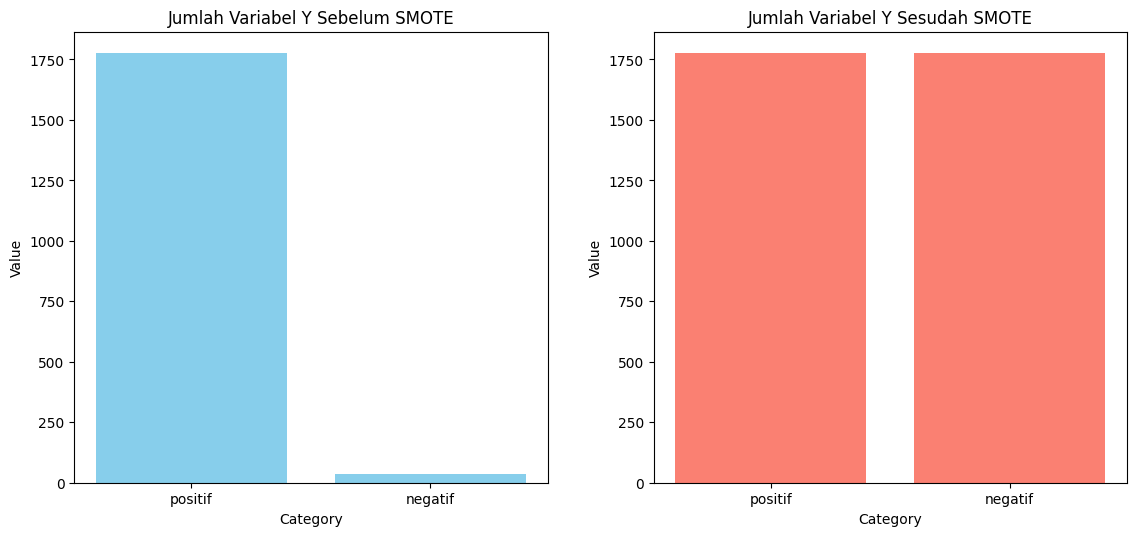

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 baris, 2 kolom, ukuran gambar

# Plot 1: Sebelum SMOTE
axes[0].bar(y.index, y.values, color='skyblue')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Value')
axes[0].set_title('Jumlah Variabel Y Sebelum SMOTE')

# Plot 2: Sesudah SMOTE
axes[1].bar(y_resampled.index, y_resampled.values, color='salmon')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Value')
axes[1].set_title('Jumlah Variabel Y Sesudah SMOTE')

# Menampilkan plot
plt.tight_layout(pad=3)  # Untuk mengatur jarak antar subplots
plt.show()

# Final Model


In [ ]:
datas = pd.read_excel('/content/Topic Dataset.xlsx')
datas = datas.dropna(subset='label').reset_index(drop=True)

pelayanan = datas[datas['topic'] == 'pelayanan'].astype(str)
administrasi = datas[datas['topic'] == 'administrasi'].astype(str)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.preprocessing import FunctionTransformer

pre = FunctionTransformer(preprocessor)
vectorizers = [TfidfVectorizer(ngram_range=(1, 3)) for _ in range(3)]
smote = SMOTE(random_state=10)

model = [naive_bayes.MultinomialNB() for _ in range(3)]

# TF IDF
X_aspek = vectorizers[0].fit_transform(datas['review'])
X_adm = vectorizers[1].fit_transform(administrasi['review'])
X_pel = vectorizers[2].fit_transform(pelayanan['review'])

# SMOTE
X_topic, y_topic = smote.fit_resample(X_aspek, datas['topic'])
X_administrasi, y_administrasi = smote.fit_resample(X_adm, administrasi['label'])
X_pelayanan, y_pelayanan = smote.fit_resample(X_pel, pelayanan['label'])

# Train Model
model_topik = model[0].fit(X_topic, y_topic)
model_administrasi = model[1].fit(X_administrasi, y_administrasi)
model_pelayanan = model[2].fit(X_pelayanan, y_pelayanan)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Perbandingan Data Sebelum & Sesudah SMOTE

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Jumlah Variabel Y Pelayanan Sesudah SMOTE')

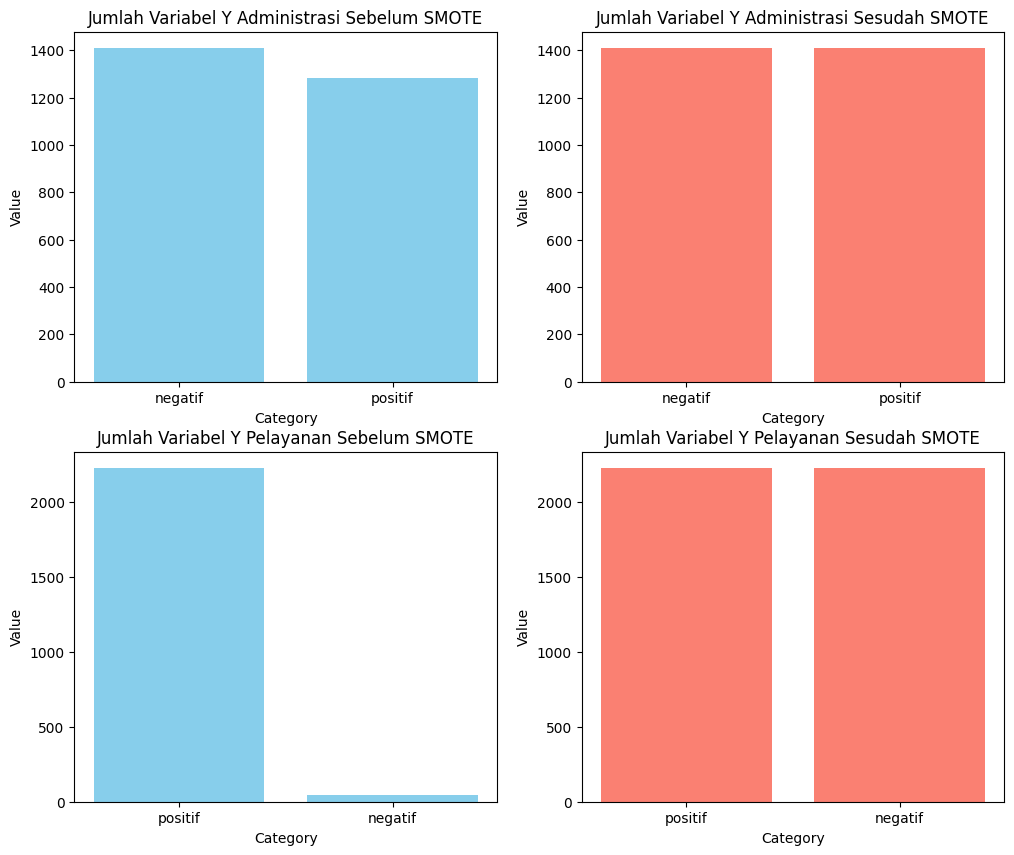

In [ ]:
adm = administrasi['label'].value_counts()
pel = pelayanan['label'].value_counts()
adm_res = y_administrasi.value_counts()
pel_res = y_pelayanan.value_counts()
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Administrasi
# Plot 1: Sebelum SMOTE
axes[0][0].bar(adm.index, adm.values, color='skyblue')
axes[0][0].set_xlabel('Category')
axes[0][0].set_ylabel('Value')
axes[0][0].set_title('Jumlah Variabel Y Administrasi Sebelum SMOTE')

# Plot 2: Sesudah SMOTE
axes[0][1].bar(adm_res.index, adm_res.values, color='salmon')
axes[0][1].set_xlabel('Category')
axes[0][1].set_ylabel('Value')
axes[0][1].set_title('Jumlah Variabel Y Administrasi Sesudah SMOTE')

# Pelayanan
# Plot 1: Sebelum SMOTE
axes[1][0].bar(pel.index, pel.values, color='skyblue')
axes[1][0].set_xlabel('Category')
axes[1][0].set_ylabel('Value')
axes[1][0].set_title('Jumlah Variabel Y Pelayanan Sebelum SMOTE')

# Plot 2: Sesudah SMOTE
axes[1][1].bar(pel_res.index, pel_res.values, color='salmon')
axes[1][1].set_xlabel('Category')
axes[1][1].set_ylabel('Value')
axes[1][1].set_title('Jumlah Variabel Y Pelayanan Sesudah SMOTE')

In [ ]:
def classification(text: str):
  result = {
      'Probs': [],
      'Label': []
  }

  if len(text) != 0:
    text = pre.fit_transform(text)
    text_aspek = vectorizers[0].transform([text])

    aspek_probs = model_topik.predict_proba(text_aspek)
    aspek_labels = model_topik.classes_

    result['Probs'].append(aspek_probs)
    result['Label'].append(aspek_labels)

    if aspek_probs[0][0] > aspek_probs[0][1]:
      text_adm = vectorizers[1].transform([text])
      adm_probs = model_administrasi.predict_proba(text_adm)
      adm_labels = model_administrasi.classes_

      result['Probs'].append(adm_probs)
      result['Label'].append(adm_labels)
    else:
      text_pel = vectorizers[1].transform([text])
      pel_probs = model_pelayanan.predict_proba(text_pel)
      pel_labels = model_pelayanan.classes_

      result['Probs'].append(pel_probs)
      result['Label'].append(pel_labels)

    print('Hasil Prediksi:')
    print('Probabilitas Aspek:')
    print(f"- Administrasi: {result['Probs'][0][0][0]:.2f}")
    print(f"- Pelayanan: {result['Probs'][0][0][1]:.2f}")
    print()
    print('Probabilitas Sentimen:')
    print(f"- Negatif: {result['Probs'][1][0][0]:.2f}")
    print(f"- Positif: {result['Probs'][1][0][1]:.2f}")
    print()

  else:
    print("Teks kosong, masukkan teks valid.")


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
classification("tempat parkirnya gratis, dokternya ramah")

Hasil Prediksi:
Probabilitas Aspek:
- Administrasi: 0.65
- Pelayanan: 0.35

Probabilitas Sentimen:
- Negatif: 0.20
- Positif: 0.80



/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
